# Classical Trading Strategies

**Created by: Pengfei Zhao**  
**© 2025 Investment Practice Course**



## Learning Objectives

In this lecture, you will learn about:
1. **Different types of trading strategies** across various asset classes (stocks, forex, pairs)
2. **The theoretical foundation** and mathematical intuition behind each strategy
3. **How to backtest strategies** using Python and evaluate their performance
4. **Risk management principles** embedded in classical trading approaches
5. **Performance metrics** to assess strategy effectiveness

We will cover strategies that span:
- **Technical indicator-based**: Moving Average Crossover
- **Statistical arbitrage**: Pairs Trading
- **Mean reversion**: Statistical pattern recognition
- **Interest rate differential**: Carry Trade (Forex)
- **Event-driven**: Merger Arbitrage / Earnings-based

Each strategy will follow this structure:
1. **Theoretical Foundation**: Mathematical formulation and intuition
2. **Market Rationale**: Why and when does this strategy work?
3. **Implementation**: Python code for backtesting
4. **Performance Evaluation**: Metrics and visualization
5. **Limitations and Risks**: What can go wrong?

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Set plotting parameters
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11


## PERFORMANCE METRICS FUNCTION (Used by all strategies)

This function must be defined early so all strategies can use it.<br>
It calculates: Total Return, Annualized Return, Sharpe Ratio, Max Drawdown, etc.

In [2]:
def calculate_performance_metrics(returns, strategy_name="Strategy"):
    """
    Calculate comprehensive performance metrics for a trading strategy
    """
    # Remove NaN values
    returns = returns.dropna()
    
    # Total return
    total_return = (1 + returns).prod() - 1
    
    # Annualized return
    n_days = len(returns)
    n_years = n_days / 252  # 252 trading days per year
    annualized_return = (1 + total_return) ** (1/n_years) - 1
    
    # Volatility (annualized)
    volatility = returns.std() * np.sqrt(252)
    
    # Sharpe Ratio (assuming risk-free rate = 2%)
    risk_free_rate = 0.02
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility if volatility != 0 else 0
    
    # Maximum Drawdown
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Win rate
    win_rate = (returns > 0).sum() / len(returns)
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{strategy_name} Performance Metrics")
    print(f"{'='*60}")
    print(f"Total Return:          {total_return*100:>10.2f}%")
    print(f"Annualized Return:     {annualized_return*100:>10.2f}%")
    print(f"Annualized Volatility: {volatility*100:>10.2f}%")
    print(f"Sharpe Ratio:          {sharpe_ratio:>10.2f}")
    print(f"Maximum Drawdown:      {max_drawdown*100:>10.2f}%")
    print(f"Win Rate:              {win_rate*100:>10.2f}%")
    print(f"Number of Trades:      {len(returns):>10.0f}")
    print(f"{'='*60}\n")
    
    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate
    }


---

## Strategy 1: Moving Average Crossover (Technical Indicator Baseline)



### 1.1 Mathematical Foundation

The Moving Average Crossover strategy is based on the relationship between two moving averages of different time periods.

**Simple Moving Average (SMA):**

$$SMA_n(t) = \frac{1}{n}\sum_{i=0}^{n-1} P_{t-i}$$

where:
- $P_t$ = Price at time $t$
- $n$ = Number of periods (window size)

**Trading Signals:**

- **Buy Signal**: $SMA_{short}(t) > SMA_{long}(t)$ (Golden Cross)
- **Sell Signal**: $SMA_{short}(t) < SMA_{long}(t)$ (Death Cross)

### 1.2 Intuition and Rationale

**Why does this work?**

1. **Trend Identification**: Moving averages smooth out price noise and reveal the underlying trend
2. **Momentum Signal**: When short-term MA crosses above long-term MA, it indicates accelerating upward momentum
3. **Lag Reduction**: Using two MAs of different lengths balances responsiveness vs. noise reduction

**Market Assumptions:**
- Markets exhibit trends (not purely random walks)
- Trends persist long enough to be profitable after transaction costs
- Historical price patterns contain information about future movements


**When does this fail?**
- **Choppy/Sideways Markets**: In range-bound or oscillating markets, moving averages generate frequent false signals, leading to whipsaws and losses from repeated buy-sell cycles
- **High Transaction Costs**: The strategy's profitability erodes when trading costs, slippage, or spreads are high, as it may require frequent position changes
- **Sudden Regime Changes**: During market crashes or rapid reversals, the lagging nature of moving averages causes delayed exits, resulting in significant drawdowns
- **Low Volatility Environments**: When price movements are minimal, the signals may not generate sufficient returns to overcome costs

### 1.3 Demonstration: Why Crossovers Indicate Trends

In [3]:
# Load stock data (downloaded from Yahoo Finance)
df = pd.read_csv('./META.csv', index_col='Date', parse_dates=True)
df = df[['Close']].copy()

# Calculate moving averages
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

# Remove NaN values
df = df.dropna()

print(f"Data period: {df.index[0]} to {df.index[-1]}")
print(f"Total trading days: {len(df)}")
df.head()

Data period: 2015-10-16 00:00:00 to 2024-09-30 00:00:00
Total trading days: 2253


,Close,SMA_50,SMA_200
Date,,,
2015-10-16,96.942375,91.274321,84.082506
2015-10-19,97.866684,91.357210,84.181993
2015-10-20,96.405685,91.413860,84.280436
2015-10-21,96.515022,91.483233,84.384594
2015-10-22,99.059326,91.592161,84.501473


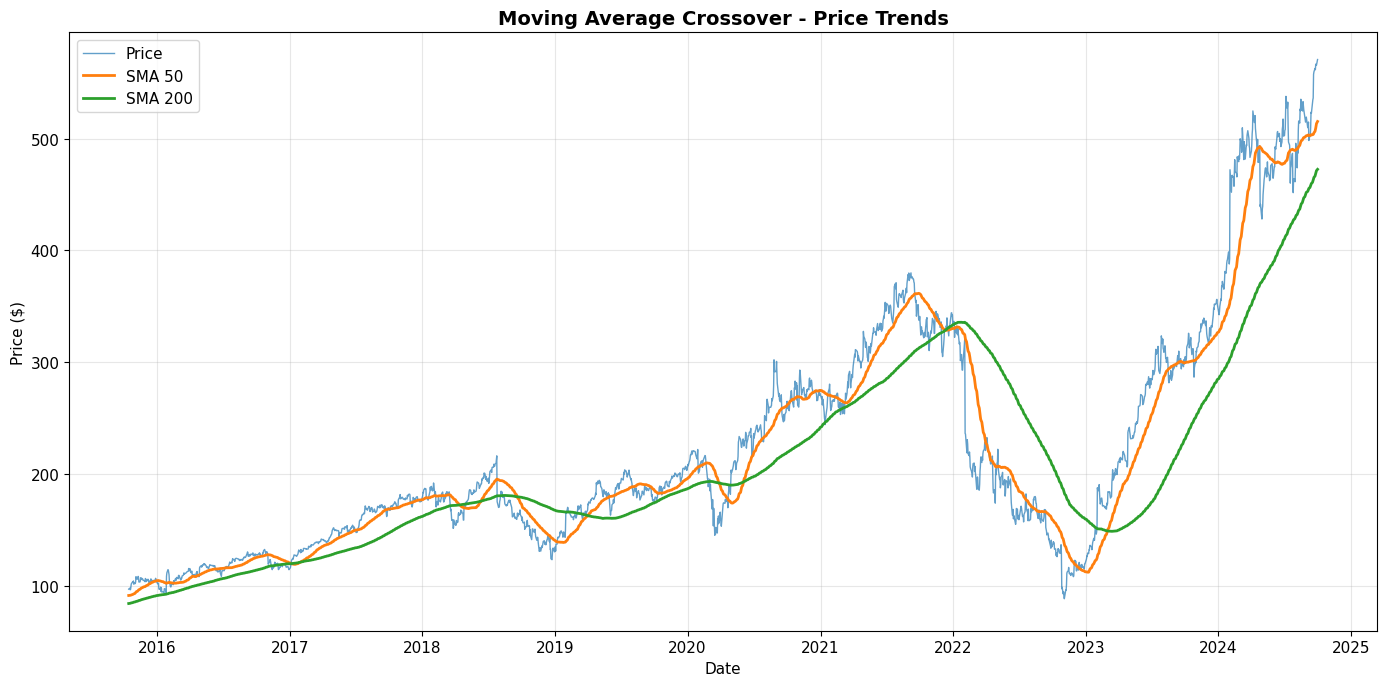

Notice how:
- When SMA_50 > SMA_200, price generally trends upward (bullish)
- When SMA_50 < SMA_200, price generally trends downward (bearish)
- Crossover points mark potential trend changes


In [4]:
# Visualize price and moving averages
plt.figure(figsize=(14, 7))

plt.plot(df.index, df['Close'], label='Price', alpha=0.7, linewidth=1)
plt.plot(df.index, df['SMA_50'], label='SMA 50', linewidth=2)
plt.plot(df.index, df['SMA_200'], label='SMA 200', linewidth=2)

plt.title('Moving Average Crossover - Price Trends', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Notice how:")
print("- When SMA_50 > SMA_200, price generally trends upward (bullish)")
print("- When SMA_50 < SMA_200, price generally trends downward (bearish)")
print("- Crossover points mark potential trend changes")

### 1.4 Strategy Implementation and Backtesting

In [5]:
# Generate trading signals
df['Signal'] = 0
df['Signal'] = np.where(df['SMA_50'] > df['SMA_200'], 1, 0)  # 1 = Long, 0 = No position

# Generate trading orders (when signal changes)
df['Position'] = df['Signal'].diff()

# Calculate returns
df['Market_Return'] = df['Close'].pct_change()
df['Strategy_Return'] = df['Market_Return'] * df['Signal'].shift(1)  # Shift to avoid look-ahead bias

# Calculate cumulative returns
df['Cumulative_Market_Return'] = (1 + df['Market_Return']).cumprod() - 1
df['Cumulative_Strategy_Return'] = (1 + df['Strategy_Return']).cumprod() - 1

# Mark buy and sell signals
buy_signals = df[df['Position'] == 1]
sell_signals = df[df['Position'] == -1]

print(f"Total Buy Signals: {len(buy_signals)}")
print(f"Total Sell Signals: {len(sell_signals)}")
print(f"\nFirst 5 trades:")
print(pd.concat([buy_signals.head(3), sell_signals.head(3)]).sort_index()[['Close', 'SMA_50', 'SMA_200', 'Position']])

Total Buy Signals: 5
Total Sell Signals: 5

First 5 trades:
                 Close      SMA_50     SMA_200  Position
Date                                                    
2017-01-06  122.653877  119.580819  119.801956      -1.0
2017-01-31  129.521530  121.137223  121.072325       1.0
2018-04-16  163.820099  171.760350  172.278701      -1.0
2018-06-12  191.221161  175.753727  175.616872       1.0
2018-09-20  165.002808  179.070283  179.547045      -1.0
2019-04-03  172.476730  163.222778  162.655923       1.0


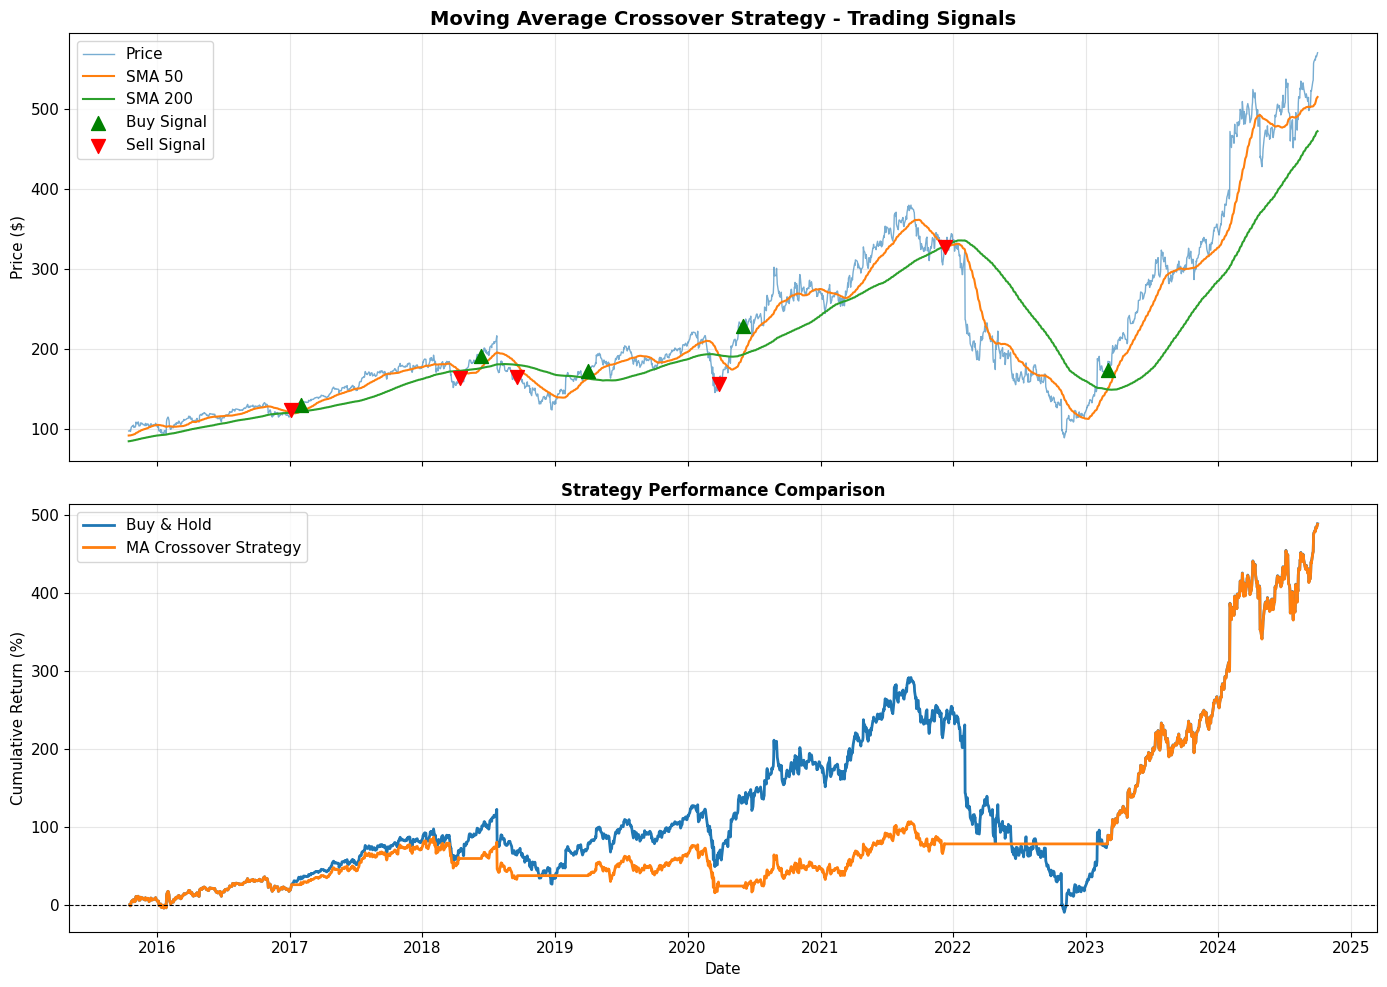

In [6]:
# Visualize trading signals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Price with buy/sell signals
ax1.plot(df.index, df['Close'], label='Price', alpha=0.6, linewidth=1)
ax1.plot(df.index, df['SMA_50'], label='SMA 50', linewidth=1.5)
ax1.plot(df.index, df['SMA_200'], label='SMA 200', linewidth=1.5)

ax1.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', s=100, label='Buy Signal', zorder=5)
ax1.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', s=100, label='Sell Signal', zorder=5)

ax1.set_ylabel('Price ($)')
ax1.set_title('Moving Average Crossover Strategy - Trading Signals', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative returns comparison
ax2.plot(df.index, df['Cumulative_Market_Return'] * 100, label='Buy & Hold', linewidth=2)
ax2.plot(df.index, df['Cumulative_Strategy_Return'] * 100, label='MA Crossover Strategy', linewidth=2)

ax2.set_ylabel('Cumulative Return (%)')
ax2.set_xlabel('Date')
ax2.set_title('Strategy Performance Comparison', fontsize=12, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

### 1.5 Performance Evaluation

In [7]:
pairs_metrics = calculate_performance_metrics(df['Strategy_Return'], "Moving Average Crossover")
print(pairs_metrics)


Moving Average Crossover Performance Metrics
Total Return:              488.01%
Annualized Return:          21.93%
Annualized Volatility:      28.34%
Sharpe Ratio:                0.70
Maximum Drawdown:          -38.03%
Win Rate:                   40.45%
Number of Trades:            2252

{'Total Return': np.float64(4.880138774220546), 'Annualized Return': np.float64(0.21925593895771467), 'Volatility': np.float64(0.28343298919047893), 'Sharpe Ratio': np.float64(0.7030089882155752), 'Max Drawdown': np.float64(-0.38025234287742815), 'Win Rate': np.float64(0.40452930728241565)}


### 1.6 Limitations and Considerations

**Weaknesses:**
1. **Lagging Indicator**: Moving averages are based on past prices, causing delayed signals
2. **Whipsaws**: In sideways markets, strategy generates many false signals
3. **Transaction Costs**: Frequent trading can erode profits
4. **Parameter Sensitivity**: Performance depends heavily on chosen MA periods

**When it works best:**
- Strong trending markets (bull or bear)
- Assets with clear momentum characteristics
- Longer timeframes to reduce noise

**When it fails:**
- Range-bound or choppy markets
- High-frequency trading (too much noise)
- Assets with sudden regime changes

---

## Strategy 2: Pairs Trading (Statistical Arbitrage)



### 2.1 Mathematical Foundation

Pairs trading exploits the mean-reverting relationship between two cointegrated assets.

**Cointegration:**

Two non-stationary time series $X_t$ and $Y_t$ are cointegrated if there exists a linear combination:

$$Z_t = Y_t - \beta X_t$$

such that $Z_t$ is stationary (mean-reverting).

**The Spread:**

$$\text{Spread}_t = \log(P^A_t) - \beta \cdot \log(P^B_t)$$

where:
- $P^A_t$ = Price of Asset A at time $t$
- $P^B_t$ = Price of Asset B at time $t$
- $\beta$ = Hedge ratio (from linear regression)

**Z-Score (Standardized Spread):**

$$Z_t = \frac{\text{Spread}_t - \mu_{\text{spread}}}{\sigma_{\text{spread}}}$$

where:
- $\mu_{\text{spread}}$ = Mean of the spread
- $\sigma_{\text{spread}}$ = Standard deviation of the spread

**Trading Signals:**
- **Enter Long** (buy spread): When $Z_t < -2$ (spread is abnormally low)
- **Enter Short** (sell spread): When $Z_t > 2$ (spread is abnormally high)
- **Exit**: When $Z_t$ crosses back through 0 (mean)

### 2.2 Intuition and Rationale

**Why does this work?**

1. **Economic Linkage**: Two stocks in the same industry or sector often move together due to:
   - Common market factors
   - Similar business models
   - Competitive dynamics
   
2. **Mean Reversion**: When the price relationship deviates significantly, market forces tend to restore the equilibrium

3. **Market Neutral**: By going long one stock and short another, you hedge out market risk and isolate the relative value opportunity

**Market Assumptions:**
- The historical relationship between the two assets will persist
- Deviations from the mean are temporary
- The hedge ratio ($\beta$) remains relatively stable


**When does this fail?**
- **Cointegration Breakdown**: When the fundamental relationship between the two assets changes (e.g., one company undergoes major restructuring, merger, or business model shift), the historical correlation breaks down permanently
- **Diverging Trends**: In strong trending markets, one asset may consistently outperform the other, causing the spread to widen indefinitely rather than revert
- **Changing Hedge Ratios**: If the β (hedge ratio) becomes unstable over time, the position may not be properly hedged, exposing the trader to directional risk
- **Liquidity Crises**: During market stress, both legs of the trade may move against you simultaneously, or one asset may become illiquid, preventing exit or adjustment

### 2.3 Demonstration: Finding Cointegrated Pairs

In [8]:
# Load data for two related stocks (Coca-Cola and Pepsi - similar sector)
ko_df = pd.read_csv('KO.csv', index_col='Date', parse_dates=True)
pep_df = pd.read_csv('PEP.csv', index_col='Date', parse_dates=True)

# Combine into pairs dataframe
pairs_df = pd.DataFrame({
    'Coca': ko_df['Close'],
    'Pepsi': pep_df['Close']
}).dropna()

# Use a subset of data for clearer demonstration
pairs_df = pairs_df['2020-01-01':'2023-12-31']

print("Real stock prices for Pairs Trading:")
print("Coca: Coca-Cola (KO)")
print("Pepsi: PepsiCo (PEP)")
print(pairs_df.head())
print(f"Data shape: {pairs_df.shape}")

Real stock prices for Pairs Trading:
Coca: Coca-Cola (KO)
Pepsi: PepsiCo (PEP)
                 Coca       Pepsi
Date                             
2020-01-02  46.066406  114.220383
2020-01-03  45.815090  114.060616
2020-01-06  45.798336  114.497910
2020-01-07  45.446495  112.698242
2020-01-08  45.530266  113.278519
Data shape: (1006, 2)


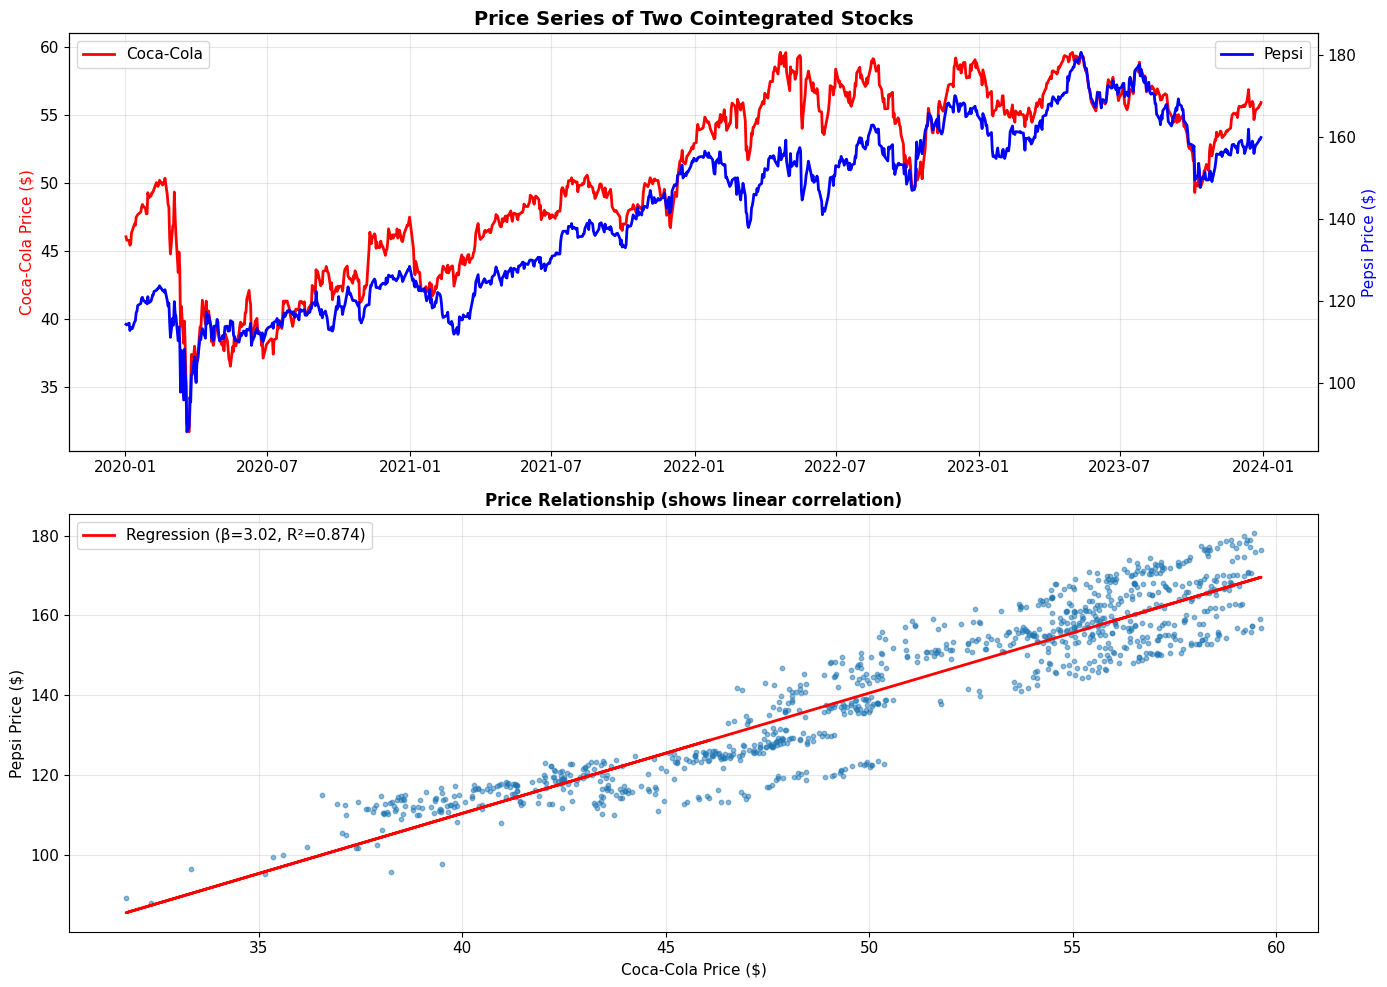

Linear relationship parameters:
Hedge ratio (β): 3.0160
R-squared: 0.8742
P-value: 0.000000


In [9]:
# Visualize the price series
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Price series
ax1 = axes[0]
ax1_twin = ax1.twinx()

ax1.plot(pairs_df.index, pairs_df['Coca'], label='Coca-Cola', color='red', linewidth=2)
ax1_twin.plot(pairs_df.index, pairs_df['Pepsi'], label='Pepsi', color='blue', linewidth=2)

ax1.set_ylabel('Coca-Cola Price ($)', color='red')
ax1_twin.set_ylabel('Pepsi Price ($)', color='blue')
ax1.set_title('Price Series of Two Cointegrated Stocks', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Scatter plot showing relationship
ax2 = axes[1]

ax2.scatter(pairs_df['Coca'], pairs_df['Pepsi'], alpha=0.5, s=10)

ax2.set_xlabel('Coca-Cola Price ($)')
ax2.set_ylabel('Pepsi Price ($)')
ax2.set_title('Price Relationship (shows linear correlation)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add regression line
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(pairs_df['Coca'], pairs_df['Pepsi'])
line = slope * pairs_df['Coca'] + intercept
ax2.plot(pairs_df['Coca'], line, 'r-', linewidth=2, label=f'Regression (β={slope:.2f}, R²={r_value**2:.3f})')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Linear relationship parameters:")
print(f"Hedge ratio (β): {slope:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.6f}")

### 2.4 Strategy Implementation and Backtesting

In [10]:
# Calculate hedge ratio using linear regression
from sklearn.linear_model import LinearRegression

# Use first 60% of data for training
train_size = int(len(pairs_df) * 0.6)
train_data = pairs_df.iloc[:train_size]
test_data = pairs_df.iloc[train_size:]

# Fit linear regression to find hedge ratio
model = LinearRegression()
model.fit(train_data[['Coca']], train_data['Pepsi'])
hedge_ratio = model.coef_[0]

print(f"Estimated hedge ratio (β): {hedge_ratio:.4f}")
print(f"Training period: {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"Testing period: {test_data.index[0].date()} to {test_data.index[-1].date()}")
print(f"Interpretation: For every $1 change in KO, PEP changes by ${hedge_ratio:.4f}")

Estimated hedge ratio (β): 2.4445
Training period: 2020-01-02 to 2022-05-23
Testing period: 2022-05-24 to 2023-12-29
Interpretation: For every $1 change in KO, PEP changes by $2.4445


In [11]:
# Calculate the spread
pairs_df['Spread'] = pairs_df['Pepsi'] - hedge_ratio * pairs_df['Coca']

# Calculate z-score (using rolling window)
window = 60  # 60-day rolling window
pairs_df['Spread_Mean'] = pairs_df['Spread'].rolling(window=window).mean()
pairs_df['Spread_Std'] = pairs_df['Spread'].rolling(window=window).std()
pairs_df['Z_Score'] = (pairs_df['Spread'] - pairs_df['Spread_Mean']) / pairs_df['Spread_Std']

# Remove NaN values
pairs_df = pairs_df.dropna()

print("Spread statistics:")
print(pairs_df[['Spread', 'Z_Score']].describe())

Spread statistics:
           Spread     Z_Score
count  947.000000  947.000000
mean    19.534088    0.228812
std      7.242888    1.373913
min      5.900974   -3.807752
25%     13.519254   -0.806388
50%     18.354464    0.234765
75%     24.985375    1.224551
max     36.051806    3.649844


In [12]:
# Generate trading signals
entry_threshold = 2.0
exit_threshold = 0.5

pairs_df['Position'] = 0  # 0 = no position, 1 = long spread, -1 = short spread

position = 0
for i in range(len(pairs_df)):
    z_score = pairs_df['Z_Score'].iloc[i]
    
    if position == 0:  # No current position
        if z_score < -entry_threshold:
            position = 1  # Enter long (buy spread: long Pepsi, short Coca Cola)
        elif z_score > entry_threshold:
            position = -1  # Enter short (sell spread: short Pepsi, long Coca Cola)
    
    elif position == 1:  # Currently long spread
        if z_score > exit_threshold:
            position = 0  # Exit
    
    elif position == -1:  # Currently short spread
        if z_score < -exit_threshold:
            position = 0  # Exit
    
    pairs_df['Position'].iloc[i] = position

# Calculate returns from the spread
pairs_df['Spread_Return'] = pairs_df['Spread'].pct_change()
pairs_df['Strategy_Return'] = pairs_df['Spread_Return'] * pairs_df['Position'].shift(1)
pairs_df['Cumulative_Strategy_Return'] = (1 + pairs_df['Strategy_Return']).cumprod() - 1

# Count trades
trades = pairs_df['Position'].diff().abs().sum() / 2
print(f"Total number of round-trip trades: {trades:.0f}")

Total number of round-trip trades: 10


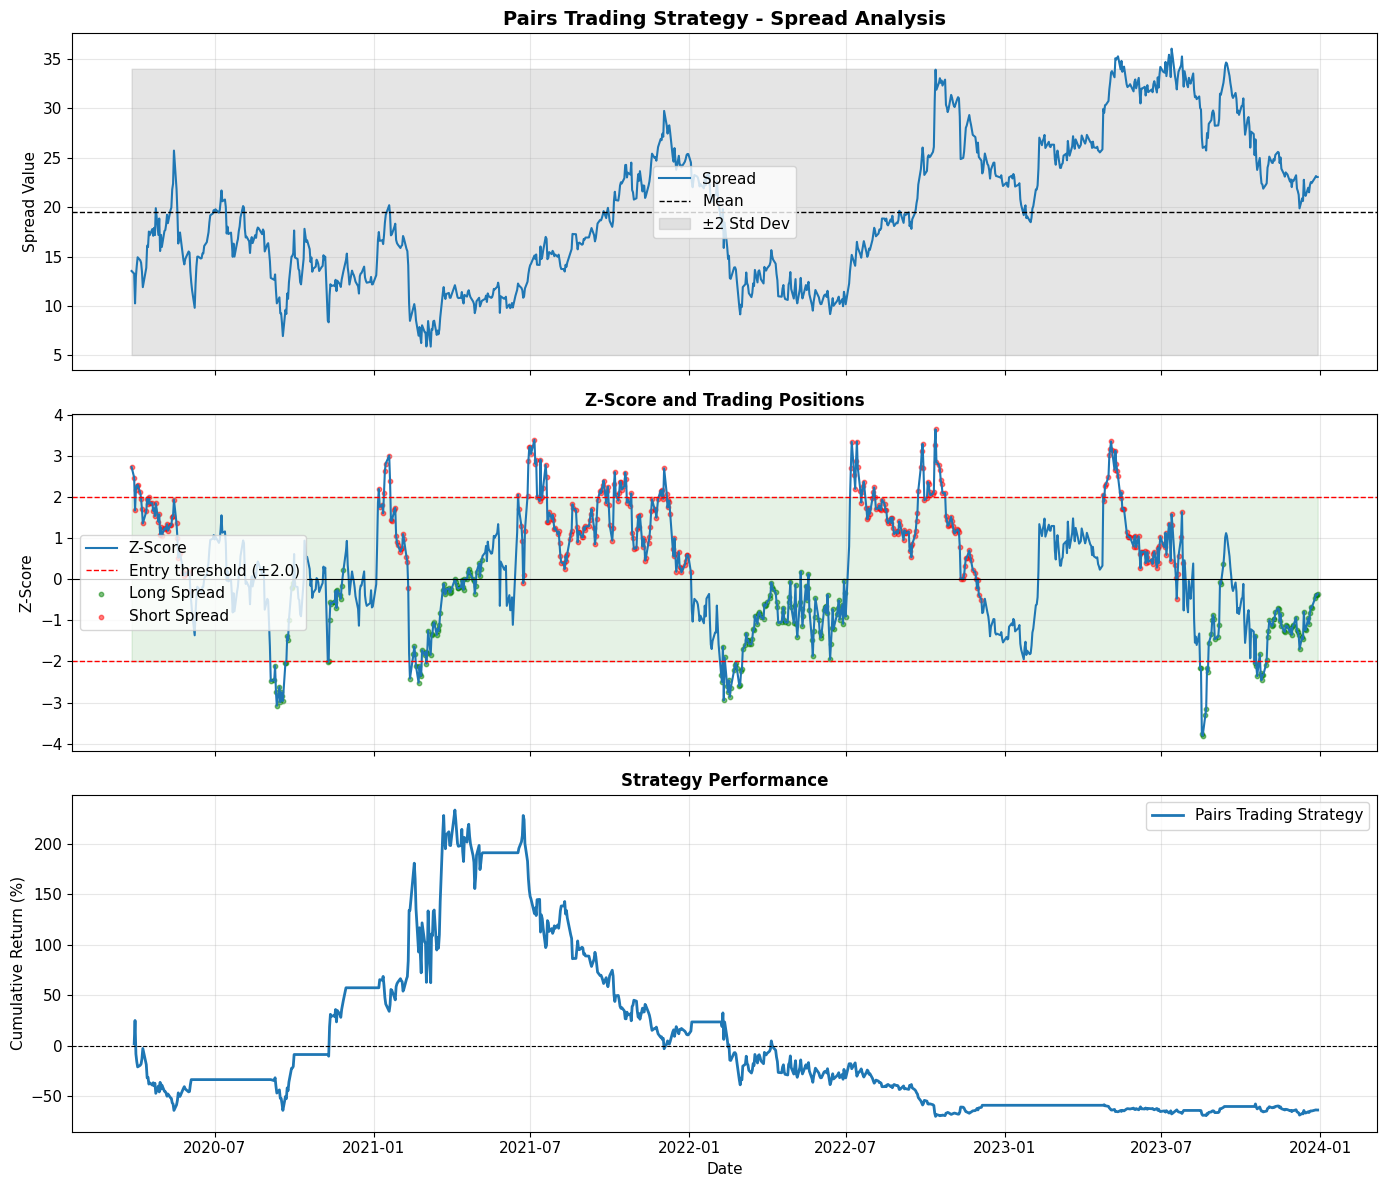

In [13]:
# Visualize pairs trading strategy
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot 1: Spread
ax1 = axes[0]

ax1.plot(pairs_df.index, pairs_df['Spread'], label='Spread', linewidth=1.5)

ax1.axhline(y=pairs_df['Spread'].mean(), color='black', linestyle='--', label='Mean', linewidth=1)
ax1.fill_between(pairs_df.index, 
                  pairs_df['Spread'].mean() - 2*pairs_df['Spread'].std(),
                  pairs_df['Spread'].mean() + 2*pairs_df['Spread'].std(),
                  alpha=0.2, color='gray', label='±2 Std Dev')
ax1.set_ylabel('Spread Value')
ax1.set_title('Pairs Trading Strategy - Spread Analysis', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Z-Score with positions
ax2 = axes[1]

ax2.plot(pairs_df.index, pairs_df['Z_Score'], label='Z-Score', linewidth=1.5)

ax2.axhline(y=entry_threshold, color='red', linestyle='--', label=f'Entry threshold (±{entry_threshold})', linewidth=1)
ax2.axhline(y=-entry_threshold, color='red', linestyle='--', linewidth=1)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.fill_between(pairs_df.index, -entry_threshold, entry_threshold, alpha=0.1, color='green')

# Mark long and short positions
long_positions = pairs_df[pairs_df['Position'] == 1]
short_positions = pairs_df[pairs_df['Position'] == -1]

ax2.scatter(long_positions.index, long_positions['Z_Score'], color='green', s=10, alpha=0.5, label='Long Spread')
ax2.scatter(short_positions.index, short_positions['Z_Score'], color='red', s=10, alpha=0.5, label='Short Spread')

ax2.set_ylabel('Z-Score')
ax2.set_title('Z-Score and Trading Positions', fontsize=12, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# Plot 3: Cumulative returns
ax3 = axes[2]

ax3.plot(pairs_df.index, pairs_df['Cumulative_Strategy_Return'] * 100, label='Pairs Trading Strategy', linewidth=2)

ax3.set_ylabel('Cumulative Return (%)')
ax3.set_xlabel('Date')
ax3.set_title('Strategy Performance', fontsize=12, fontweight='bold')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

### 2.5 Performance Evaluation

In [14]:
# Calculate performance metrics
pairs_metrics = calculate_performance_metrics(pairs_df['Strategy_Return'], "Pairs Trading Strategy")

print("\nAdditional Pairs Trading Metrics:")
print(f"Average time in position: {(pairs_df['Position'] != 0).sum() / trades:.1f} days per trade")
print(f"Percentage of time invested: {(pairs_df['Position'] != 0).sum() / len(pairs_df) * 100:.1f}%")


Pairs Trading Strategy Performance Metrics
Total Return:              -63.60%
Annualized Return:         -23.60%
Annualized Volatility:      93.02%
Sharpe Ratio:               -0.28
Maximum Drawdown:          -90.98%
Win Rate:                   31.82%
Number of Trades:             946


Additional Pairs Trading Metrics:
Average time in position: 64.2 days per trade
Percentage of time invested: 67.8%


Think about it, why the performance is so poor, what is the problem?

### 2.6 Limitations and Considerations

**Weaknesses:**
1. **Cointegration Breakdown**: The historical relationship may break down due to:
   - Structural changes in businesses
   - Merger/acquisition activity
   - Regulatory changes
   
2. **Execution Risk**: Requires simultaneous execution of two legs (long and short)

3. **Capital Intensive**: Requires margin for short positions

4. **Parameter Sensitivity**: Performance depends on threshold choices and lookback windows

**When it works best:**
- Strongly cointegrated pairs (R² > 0.85)
- Liquid assets with tight spreads
- Stable market conditions

**When it fails:**
- Structural breaks in relationships
- Extreme market conditions (2008 crisis)
- High transaction costs

---

## Strategy 3: Mean Reversion Strategy (Statistical Pattern-Based)



### 3.1 Mathematical Foundation

Mean reversion strategies exploit the tendency of asset prices to return to their historical average.

**Ornstein-Uhlenbeck Process:**

$$dP_t = \theta(\mu - P_t)dt + \sigma dW_t$$

where:
- $P_t$ = Price at time $t$
- $\mu$ = Long-term mean price
- $\theta$ = Speed of mean reversion (larger = faster reversion)
- $\sigma$ = Volatility
- $dW_t$ = Wiener process (random noise)

**Bollinger Bands (Practical Implementation):**

$$\text{Middle Band} = SMA_n(P_t)$$
$$\text{Upper Band} = SMA_n(P_t) + k \cdot \sigma_n(P_t)$$
$$\text{Lower Band} = SMA_n(P_t) - k \cdot \sigma_n(P_t)$$

where:
- $SMA_n$ = Simple moving average over $n$ periods
- $\sigma_n$ = Standard deviation over $n$ periods
- $k$ = Number of standard deviations (typically 2)

**Trading Signals:**
- **Buy**: When $P_t < \text{Lower Band}$ (price is "too low")
- **Sell**: When $P_t > \text{Upper Band}$ (price is "too high")
- **Exit**: When $P_t$ returns to Middle Band

### 3.2 Intuition and Rationale

**Why does this work?**

1. **Market Overreaction**: Prices often overreact to news, creating temporary deviations from fair value
2. **Statistical Normality**: Many assets exhibit mean-reverting behavior around a long-term equilibrium
3. **Arbitrage Forces**: When prices deviate too far, arbitrageurs step in to profit, pushing price back
4. **Volatility Adjustment**: Bollinger Bands adapt to changing volatility conditions

**Market Assumptions:**
- Prices fluctuate around a stable mean
- Extreme deviations are temporary
- No fundamental regime changes


**When does this fail?**
- **Trending Markets**: When strong, persistent trends develop, mean reversion strategies fight the trend, accumulating losses as prices move further from the mean instead of reverting
- **Regime Changes**: Fundamental shifts (e.g., company entering bankruptcy, major industry disruption) cause the mean itself to shift, making historical mean levels irrelevant
- **Volatility Expansion**: During crisis periods, volatility increases dramatically, causing Bollinger Bands to widen significantly. Prices may reach "extreme" levels and continue moving further
- **"Catching Falling Knives"**: In assets experiencing genuine deterioration, buying oversold conditions can lead to severe losses as prices continue declining to new lows

### 3.3 Demonstration: Mean-Reverting Behavior

In [15]:
# Load data (Apple stock for mean reversion strategy)
# Using only recent data (2023-2025) for mean reversion analysis
mr_df = pd.read_csv('AAPL.csv', index_col='Date', parse_dates=True)
mr_df = mr_df[['Close']].copy()

# Filter to 2023-2025 period only
mr_df = mr_df[mr_df.index >= '2023-01-01']

# Calculate Bollinger Bands
window = 20
num_std = 2

mr_df['SMA'] = mr_df['Close'].rolling(window=window).mean()
mr_df['STD'] = mr_df['Close'].rolling(window=window).std()
mr_df['Upper_Band'] = mr_df['SMA'] + num_std * mr_df['STD']
mr_df['Lower_Band'] = mr_df['SMA'] - num_std * mr_df['STD']

# Calculate distance from mean (in standard deviations)
mr_df['Distance_from_Mean'] = (mr_df['Close'] - mr_df['SMA']) / mr_df['STD']

# Remove NaN
mr_df = mr_df.dropna()

print(f"Data period: {mr_df.index[0]} to {mr_df.index[-1]}")
print(f"\nBollinger Bands Parameters:")
print(f"Window: {window} days")
print(f"Standard deviations: {num_std}")
print(f"\nSample data:")
print(mr_df[['Close', 'SMA', 'Upper_Band', 'Lower_Band', 'Distance_from_Mean']].tail())


Data period: 2023-01-31 00:00:00 to 2024-09-30 00:00:00

Bollinger Bands Parameters:
Window: 20 days
Standard deviations: 2

Sample data:
                 Close         SMA  Upper_Band  Lower_Band  Distance_from_Mean
Date                                                                          
2024-09-24  226.316727  222.653268  230.748497  214.558038            0.905091
2024-09-25  225.321350  222.570652  230.512504  214.628800            0.692709
2024-09-26  226.466034  222.621914  230.654487  214.589341            0.957133
2024-09-27  226.734772  222.522378  230.281167  214.763589            1.085838
2024-09-30  231.920624  222.721451  231.233203  214.209698            2.161523


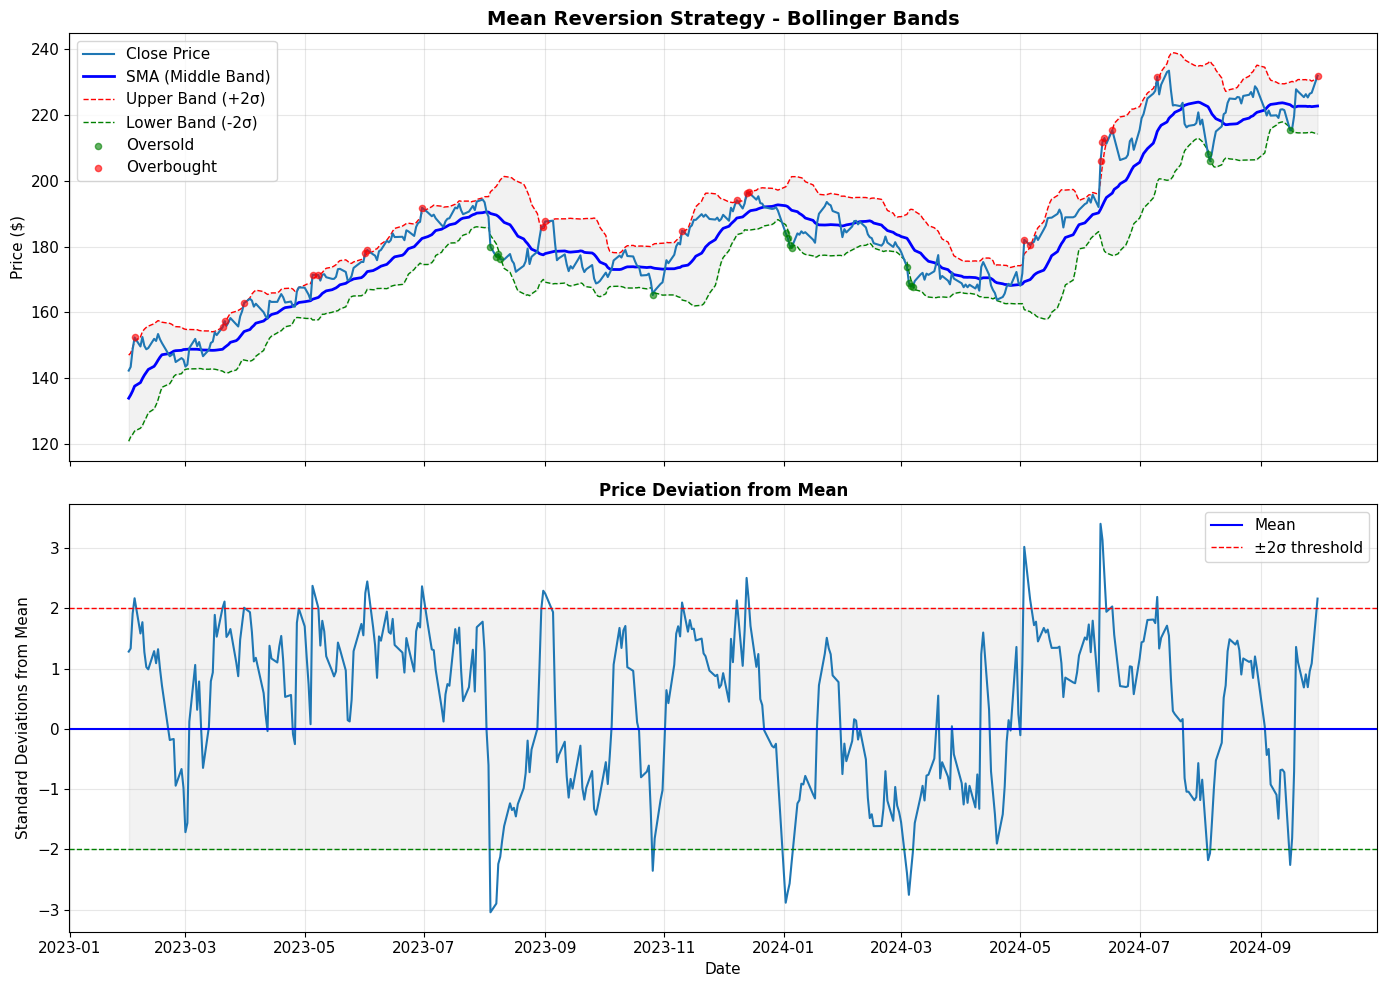


Observations:
Times price touched lower band (oversold): 16
Times price touched upper band (overbought): 23
Percentage of time outside bands: 9.31%

Note: Price tends to return toward the middle band after touching extremes


In [16]:
# Visualize Bollinger Bands and mean reversion
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Price with Bollinger Bands
ax1 = axes[0]

ax1.plot(mr_df.index, mr_df['Close'], label='Close Price', linewidth=1.5, zorder=5)
ax1.plot(mr_df.index, mr_df['SMA'], label='SMA (Middle Band)', color='blue', linewidth=2)
ax1.plot(mr_df.index, mr_df['Upper_Band'], '--', label='Upper Band (+2σ)', color='red', linewidth=1)
ax1.plot(mr_df.index, mr_df['Lower_Band'], '--', label='Lower Band (-2σ)', color='green', linewidth=1)

ax1.fill_between(mr_df.index, mr_df['Lower_Band'], mr_df['Upper_Band'], alpha=0.1, color='gray')

# Highlight extreme deviations
oversold = mr_df[mr_df['Close'] < mr_df['Lower_Band']]
overbought = mr_df[mr_df['Close'] > mr_df['Upper_Band']]

ax1.scatter(oversold.index, oversold['Close'], color='green', s=20, alpha=0.6, label='Oversold', zorder=6)
ax1.scatter(overbought.index, overbought['Close'], color='red', s=20, alpha=0.6, label='Overbought', zorder=6)

ax1.set_ylabel('Price ($)')
ax1.set_title('Mean Reversion Strategy - Bollinger Bands', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Distance from mean
ax2 = axes[1]

ax2.plot(mr_df.index, mr_df['Distance_from_Mean'], linewidth=1.5)

ax2.axhline(y=0, color='blue', linestyle='-', linewidth=1.5, label='Mean')
ax2.axhline(y=2, color='red', linestyle='--', linewidth=1, label='±2σ threshold')
ax2.axhline(y=-2, color='green', linestyle='--', linewidth=1)
ax2.fill_between(mr_df.index, -2, 2, alpha=0.1, color='gray')
ax2.set_ylabel('Standard Deviations from Mean')
ax2.set_xlabel('Date')
ax2.set_title('Price Deviation from Mean', fontsize=12, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print(f"Times price touched lower band (oversold): {len(oversold)}")
print(f"Times price touched upper band (overbought): {len(overbought)}")
print(f"Percentage of time outside bands: {((len(oversold) + len(overbought)) / len(mr_df) * 100):.2f}%")
print("\nNote: Price tends to return toward the middle band after touching extremes")

### 3.4 Strategy Implementation and Backtesting

In [17]:
# Implement mean reversion strategy (long-only, no shorting)
mr_df['Position'] = 0  # 0 = no position, 1 = long
mr_df['Signal'] = 0    # 1 = buy signal, -1 = sell signal, 0 = hold

position = 0

for i in range(len(mr_df)):
    close = mr_df['Close'].iloc[i]
    upper = mr_df['Upper_Band'].iloc[i]
    lower = mr_df['Lower_Band'].iloc[i]
    sma = mr_df['SMA'].iloc[i]
    
    # Entry signals (only when position is 0)
    if position == 0:
        if close < lower:
            position = 1  # Buy (expect price to rise back to mean)
            mr_df['Signal'].iloc[i] = 1
        # Do NOT enter short when close > upper (no shorting allowed)
    
    # Exit signals (when holding long position)
    elif position == 1:
        if close >= upper:  # Exit when price returns to mean
            mr_df['Signal'].iloc[i] = -1  # Sell signal
            position = 0  # Exit long
    
    mr_df['Position'].iloc[i] = position

# Calculate returns
mr_df['Market_Return'] = mr_df['Close'].pct_change()
mr_df['Strategy_Return'] = mr_df['Market_Return'] * mr_df['Position'].shift(1)
mr_df['Cumulative_Market'] = (1 + mr_df['Market_Return']).cumprod() - 1
mr_df['Cumulative_Strategy'] = (1 + mr_df['Strategy_Return']).cumprod() - 1

# Count trades
num_trades = (mr_df['Position'].diff().abs() > 0).sum() / 2
print(f"Total number of round-trip trades: {num_trades:.0f}")
print(f"Average trades per year: {num_trades / (len(mr_df) / 252):.1f}")


Total number of round-trip trades: 4
Average trades per year: 2.4


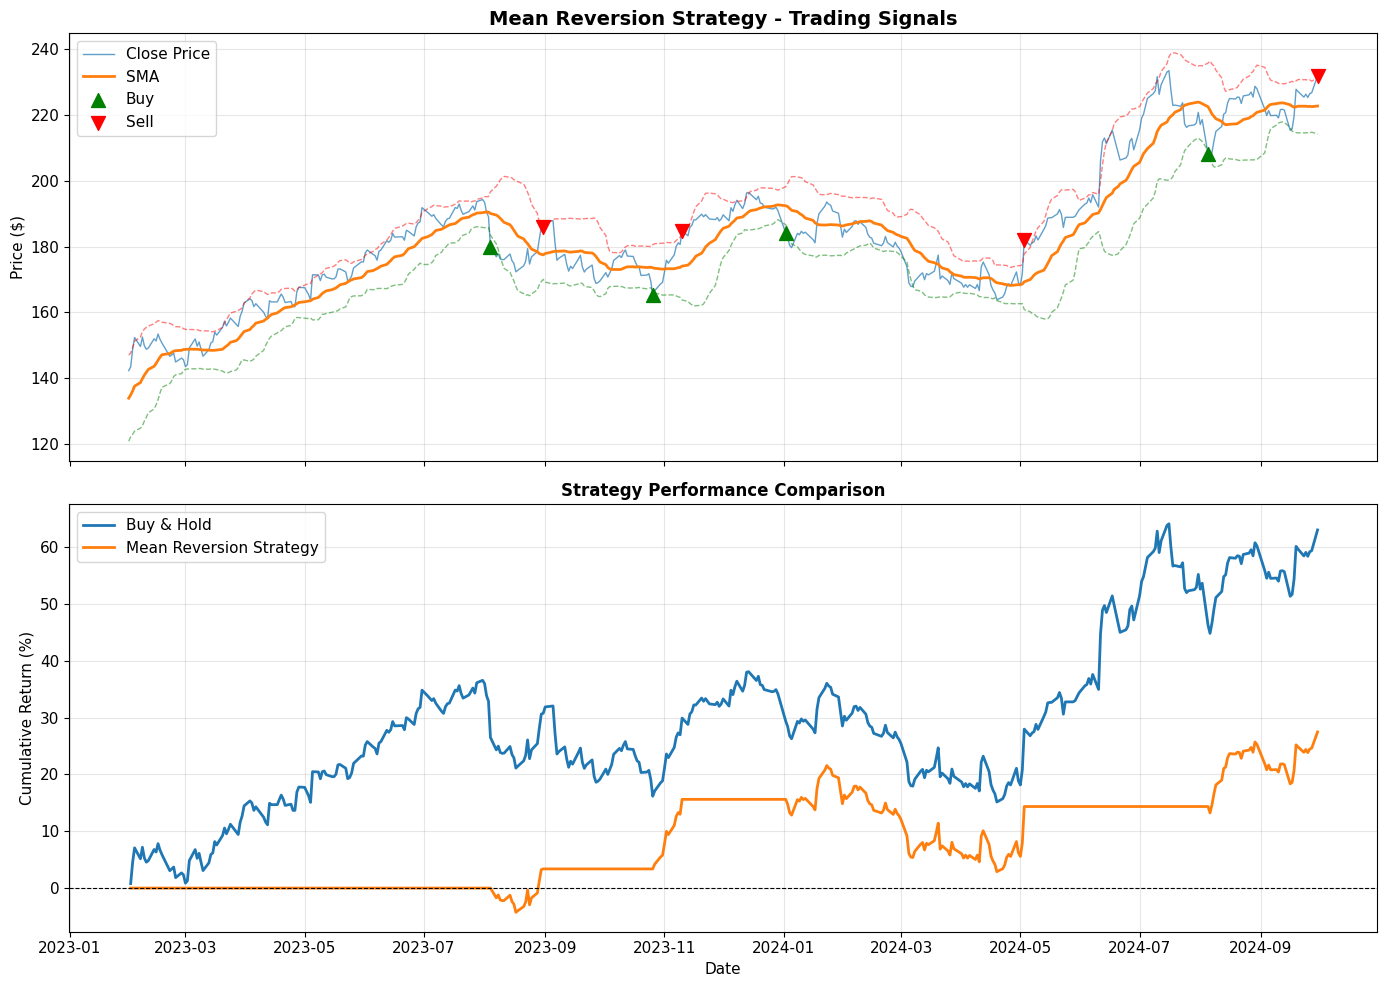

In [18]:
# Visualize strategy performance
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Price with trading signals
ax1 = axes[0]

ax1.plot(mr_df.index, mr_df['Close'], label='Close Price', linewidth=1, alpha=0.7)
ax1.plot(mr_df.index, mr_df['SMA'], label='SMA', linewidth=2)
ax1.plot(mr_df.index, mr_df['Upper_Band'], '--', color='red', linewidth=1, alpha=0.5)
ax1.plot(mr_df.index, mr_df['Lower_Band'], '--', color='green', linewidth=1, alpha=0.5)

# Mark buy and sell signals
buy_signals = mr_df[mr_df['Signal'] == 1]
sell_signals = mr_df[mr_df['Signal'] == -1]

ax1.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', s=100, label='Buy', zorder=5)
ax1.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', s=100, label='Sell', zorder=5)

ax1.set_ylabel('Price ($)')
ax1.set_title('Mean Reversion Strategy - Trading Signals', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative returns
ax2 = axes[1]

ax2.plot(mr_df.index, mr_df['Cumulative_Market'] * 100, label='Buy & Hold', linewidth=2)
ax2.plot(mr_df.index, mr_df['Cumulative_Strategy'] * 100, label='Mean Reversion Strategy', linewidth=2)

ax2.set_ylabel('Cumulative Return (%)')
ax2.set_xlabel('Date')
ax2.set_title('Strategy Performance Comparison', fontsize=12, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

### 3.5 Performance Evaluation

In [19]:
# Calculate performance metrics
mr_metrics = calculate_performance_metrics(mr_df['Strategy_Return'], "Mean Reversion Strategy")
market_metrics_mr = calculate_performance_metrics(mr_df['Market_Return'], "Buy & Hold (MR Period)")

print("\nAdditional Mean Reversion Metrics:")
print(f"Average holding period: {(mr_df['Position'] != 0).sum() / (num_trades or 1):.1f} days per trade")
print(f"Percentage of time invested: {(mr_df['Position'] != 0).sum() / len(mr_df) * 100:.1f}%")


Mean Reversion Strategy Performance Metrics
Total Return:               27.46%
Annualized Return:          15.75%
Annualized Volatility:      13.29%
Sharpe Ratio:                1.03
Maximum Drawdown:          -15.35%
Win Rate:                   19.38%
Number of Trades:             418


Buy & Hold (MR Period) Performance Metrics
Total Return:               63.00%
Annualized Return:          34.25%
Annualized Volatility:      21.82%
Sharpe Ratio:                1.48
Maximum Drawdown:          -16.61%
Win Rate:                   55.02%
Number of Trades:             418


Additional Mean Reversion Metrics:
Average holding period: 38.5 days per trade
Percentage of time invested: 36.8%


Think about it, why the strategy performs worse than the buy-and-hold strategy?

### 3.6 Limitations and Considerations

**Weaknesses:**
1. **Trending Markets**: Strategy performs poorly when strong trends emerge
2. **Regime Changes**: Assumes mean is stable, but it can shift permanently
3. **Parameter Sensitivity**: Window size and standard deviation thresholds greatly affect results
4. **Short Selling**: May require ability to short, with associated costs and risks

**When it works best:**
- Range-bound, sideways markets
- Assets with stable fundamentals
- High-frequency data with noise
- Assets with strong support/resistance levels

**When it fails:**
- Strong trending markets (bull or bear)
- Structural changes in asset value
- Black swan events
- "Catching a falling knife" situations

---

## Strategy 4: Carry Trade (Interest Rate Differential - Forex)


A carry trade is any strategy where an investor borrows capital at a lower interest rate to invest in assets with potentially higher returns.

### 4.1 Mathematical Foundation

The carry trade exploits interest rate differentials between currencies.

**Interest Rate Parity (IRP):**

Under covered interest rate parity:

$$\frac{F_t}{S_t} = \frac{1 + r_d}{1 + r_f}$$

where:
- $F_t$ = Forward exchange rate
- $S_t$ = Spot exchange rate
- $r_d$ = Domestic interest rate
- $r_f$ = Foreign interest rate

**Carry Trade Return:**

$$R_{carry} = (r_{high} - r_{low}) + \Delta S$$

where:
- $r_{high}$ = Interest rate of high-yield currency
- $r_{low}$ = Interest rate of low-yield currency
- $\Delta S$ = Change in exchange rate

**Expected Return (Uncovered Interest Parity Deviation):**

$$E[R_{carry}] = (r_{high} - r_{low}) + E[\Delta S]$$

Carry trades profit when: $E[\Delta S] \geq -(r_{high} - r_{low})$

That is, the high-yield currency doesn't depreciate by more than the interest rate differential.

### 4.2 Intuition and Rationale

**Why does this work?**

1. **Interest Rate Differential**: Earn positive carry by borrowing low-yield currency, investing in high-yield
2. **UIP Violation**: Uncovered Interest Parity often doesn't hold - high-yield currencies don't always depreciate as theory predicts
3. **Risk Premium**: High-yield currencies may offer a risk premium that compensates investors
4. **Leverage**: Forex markets allow significant leverage, amplifying carry returns

**Market Assumptions:**
- Interest rate differentials persist over investment horizon
- Exchange rates remain relatively stable or move favorably
- Carry currencies maintain liquidity

**Popular Carry Pairs (Historical):**
- **USD/JPY**: US Dollar (higher yield) vs. Japanese Yen (low yield)



**When does this fail?**
- **Sudden Risk-Off Events**: During global crises (financial crashes, geopolitical shocks), carry currencies often experience sharp, rapid depreciation that more than wipes out accumulated interest income
- **Interest Rate Convergence**: When central banks coordinate policy or high-yield countries cut rates, the interest differential narrows or disappears, eliminating the carry advantage
- **Unwinding Cascades**: Carry trades are often crowded - when many traders exit simultaneously (deleveraging), it creates self-reinforcing currency depreciation in high-yield currencies
- **Liquidity Dry-Ups**: During market stress, forex market liquidity can evaporate, making it difficult to exit positions or causing severe slippage
- **Leverage Amplification**: The use of leverage magnifies losses when exchange rates move unfavorably, potentially leading to margin calls and forced liquidation

### 4.3 Demonstration: Interest Rate Differentials and Carry Returns

#### Data Preparation: Creating the Carry Trade Dataset

Before analyzing the carry trade strategy, we need to combine three separate data files into a single comprehensive dataset:

**Input Files (provided):**
1. **USDJPY.csv** - Real USD/JPY exchange rates from Yahoo Finance
2. **US_2Y_Rate.csv** - US 2-Year Treasury yields
3. **JP_2Y_Rate.csv** - Japan 2-Year Government Bond yields

**Processing Steps:**
1. Load the three CSV files
2. Merge them by date (keeping only dates present in all files)
3. Calculate carry trade metrics:
   - **Carry_Differential**: Interest rate differential (US_Rate - JP_Rate)
   - **Daily_Carry**: Daily return from interest rate differential
   - **FX_Return**: Daily return from exchange rate changes
   - **Carry_Trade_Return**: Total return (Daily_Carry + FX_Return)
4. Calculate cumulative returns for each component
5. Save as **USDJPY_CarryTrade.csv**

**Note:** You only need to run this cell once to create the combined dataset. After that, you can directly load USDJPY_CarryTrade.csv in subsequent analyses.

In [20]:
# Assume we have three pre-existing data files:
# - USDJPY.csv: USD/JPY exchange rate data
# - US_2Y_Rate.csv: US 2-Year Treasury yield data
# - JP_2Y_Rate.csv: Japan 2-Year Government Bond yield data

# Step 1: Load the three datasets
print("Loading market data files...")
exchange_df = pd.read_csv('USDJPY.csv', index_col='Date', parse_dates=True)
us_df = pd.read_csv('US_2Y_Rate.csv', index_col='Date', parse_dates=True)
jp_df = pd.read_csv('JP_2Y_Rate.csv', index_col='Date', parse_dates=True)

print(f"  ✓ Loaded USDJPY.csv: {len(exchange_df)} days")
print(f"  ✓ Loaded US_2Y_Rate.csv: {len(us_df)} days")
print(f"  ✓ Loaded JP_2Y_Rate.csv: {len(jp_df)} days")

# Step 2: Merge the datasets on date (inner join to keep only common dates)
print("\nMerging datasets...")
carry_data = pd.DataFrame({
    'Exchange_Rate': exchange_df['Exchange_Rate'],
    'US_Rate': us_df['US_2Y_Yield'],
    'JP_Rate': jp_df['JP_2Y_Yield']
})

# Forward fill any missing values
carry_data = carry_data.ffill()
print(f"  ✓ Combined dataset: {len(carry_data)} days")

# Step 3: Calculate carry trade metrics
print("\nCalculating carry trade metrics...")

# Interest rate differential (in percentage points)
carry_data['Carry_Differential'] = carry_data['US_Rate'] - carry_data['JP_Rate']

# Convert annual percentage to daily decimal return
carry_data['Daily_Carry'] = carry_data['Carry_Differential'] / 365 / 100

# Calculate FX return (daily percentage change in exchange rate)
carry_data['FX_Return'] = carry_data['Exchange_Rate'].pct_change()

# Total carry trade return = interest earned + FX movement
carry_data['Carry_Trade_Return'] = carry_data['Daily_Carry'] + carry_data['FX_Return']

# Step 4: Calculate cumulative returns
print("Calculating cumulative returns...")
carry_data['Cumulative_Carry'] = (1 + carry_data['Daily_Carry']).cumprod() - 1
carry_data['Cumulative_FX'] = (1 + carry_data['FX_Return'].fillna(0)).cumprod() - 1
carry_data['Cumulative_Interest'] = (1 + carry_data['Carry_Trade_Return'].fillna(0)).cumprod() - 1

# Step 5: Save the combined carry trade dataset
carry_data.to_csv('USDJPY_CarryTrade.csv')
print(f"\n✓ Created USDJPY_CarryTrade.csv with {len(carry_data)} days of data")
print(f"  Date range: {carry_data.index[0].strftime('%Y-%m-%d')} to {carry_data.index[-1].strftime('%Y-%m-%d')}")
print(f"  Average carry differential: {carry_data['Carry_Differential'].mean():.2f}%")
print(f"  Average exchange rate: {carry_data['Exchange_Rate'].mean():.2f} JPY/USD")

# Display the first few rows
print("\nFirst 5 rows of USDJPY_CarryTrade.csv:")
print(carry_data.head().to_string())

Loading market data files...
  ✓ Loaded USDJPY.csv: 2806 days
  ✓ Loaded US_2Y_Rate.csv: 1046 days
  ✓ Loaded JP_2Y_Rate.csv: 3938 days

Merging datasets...
  ✓ Combined dataset: 3938 days

Calculating carry trade metrics...
Calculating cumulative returns...

✓ Created USDJPY_CarryTrade.csv with 3938 days of data
  Date range: 2015-01-01 to 2025-10-12
  Average carry differential: 3.54%
  Average exchange rate: 122.16 JPY/USD

First 5 rows of USDJPY_CarryTrade.csv:
            Exchange_Rate  US_Rate   JP_Rate  Carry_Differential  Daily_Carry  FX_Return  Carry_Trade_Return  Cumulative_Carry  Cumulative_FX  Cumulative_Interest
Date                                                                                                                                                              
2015-01-01     119.672997      NaN  0.070187                 NaN          NaN        NaN                 NaN               NaN       0.000000                  0.0
2015-01-02     119.870003      NaN  0.025

In [21]:
# Load real forex and interest rate data
# This dataset contains actual USD/JPY exchange rates and 2-year bond yields
carry_df = pd.read_csv('USDJPY_CarryTrade.csv', index_col='Date', parse_dates=True)

# Extract key columns
exchange_rate = carry_df['Exchange_Rate']
us_rate = carry_df['US_Rate'] / 100  # Convert from percentage to decimal
jp_rate = carry_df['JP_Rate'] / 100  # Convert from percentage to decimal
carry_differential = carry_df['Carry_Differential'] / 100  # Convert from percentage to decimal

# Display data summary
print("Carry Trade Data (Real USD/JPY and 2-Year Bond Yields):")
print(f"\nData Period: {carry_df.index[0].strftime('%Y-%m-%d')} to {carry_df.index[-1].strftime('%Y-%m-%d')}")
print(f"Number of observations: {len(carry_df)}")
print(f"\nInterest Rates (Average):")
print(f"  US 2-Year Treasury Yield: {us_rate.mean()*100:.2f}%")
print(f"  Japan 2-Year Gov't Bond Yield: {jp_rate.mean()*100:.2f}%")
print(f"  Average Carry Differential: {carry_differential.mean()*100:.2f}%")
print(f"\nInterest Rates (Latest):")
print(f"  US 2-Year Treasury Yield: {us_rate.iloc[-1]*100:.2f}%")
print(f"  Japan 2-Year Gov't Bond Yield: {jp_rate.iloc[-1]*100:.2f}%")
print(f"  Latest Carry Differential: {carry_differential.iloc[-1]*100:.2f}%")
print(f"\nExchange Rate Range:")
print(f"  Starting: {carry_df['Exchange_Rate'].iloc[0]:.2f} JPY per USD")
print(f"  Ending: {carry_df['Exchange_Rate'].iloc[-1]:.2f} JPY per USD")
print(f"  Min: {carry_df['Exchange_Rate'].min():.2f} JPY per USD")
print(f"  Max: {carry_df['Exchange_Rate'].max():.2f} JPY per USD")

Carry Trade Data (Real USD/JPY and 2-Year Bond Yields):

Data Period: 2015-01-01 to 2025-10-12
Number of observations: 3938

Interest Rates (Average):
  US 2-Year Treasury Yield: 3.63%
  Japan 2-Year Gov't Bond Yield: 0.02%
  Average Carry Differential: 3.54%

Interest Rates (Latest):
  US 2-Year Treasury Yield: 3.59%
  Japan 2-Year Gov't Bond Yield: 0.23%
  Latest Carry Differential: 3.36%

Exchange Rate Range:
  Starting: 119.67 JPY per USD
  Ending: 151.12 JPY per USD
  Min: 99.91 JPY per USD
  Max: 161.62 JPY per USD


In [22]:
carry_df

,Exchange_Rate,US_Rate,JP_Rate,Carry_Differential,Daily_Carry,FX_Return,Carry_Trade_Return,Cumulative_Carry,Cumulative_FX,Cumulative_Interest
Date,,,,,,,,,,
2015-01-01,119.672997,NaN,0.070187,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2015-01-02,119.870003,NaN,0.025931,NaN,NaN,0.001646,NaN,NaN,0.001646,0.000000
2015-01-03,119.870003,NaN,0.045328,NaN,NaN,0.000000,NaN,NaN,0.001646,0.000000
2015-01-04,119.870003,NaN,0.058545,NaN,NaN,0.000000,NaN,NaN,0.001646,0.000000
2015-01-05,120.433998,NaN,0.052264,NaN,NaN,0.004705,NaN,NaN,0.006359,0.000000
...,...,...,...,...,...,...,...,...,...,...
2025-10-08,152.050995,3.590,0.217878,3.372122,0.000092,0.011441,0.011534,0.158476,0.270554,0.595875
2025-10-09,152.679993,3.590,0.159346,3.430654,0.000094,0.004137,0.004231,0.158585,0.275810,0.602627
2025-10-10,151.119003,3.585,0.192724,3.392276,0.000093,-0.010224,-0.010131,0.158693,0.262766,0.586391


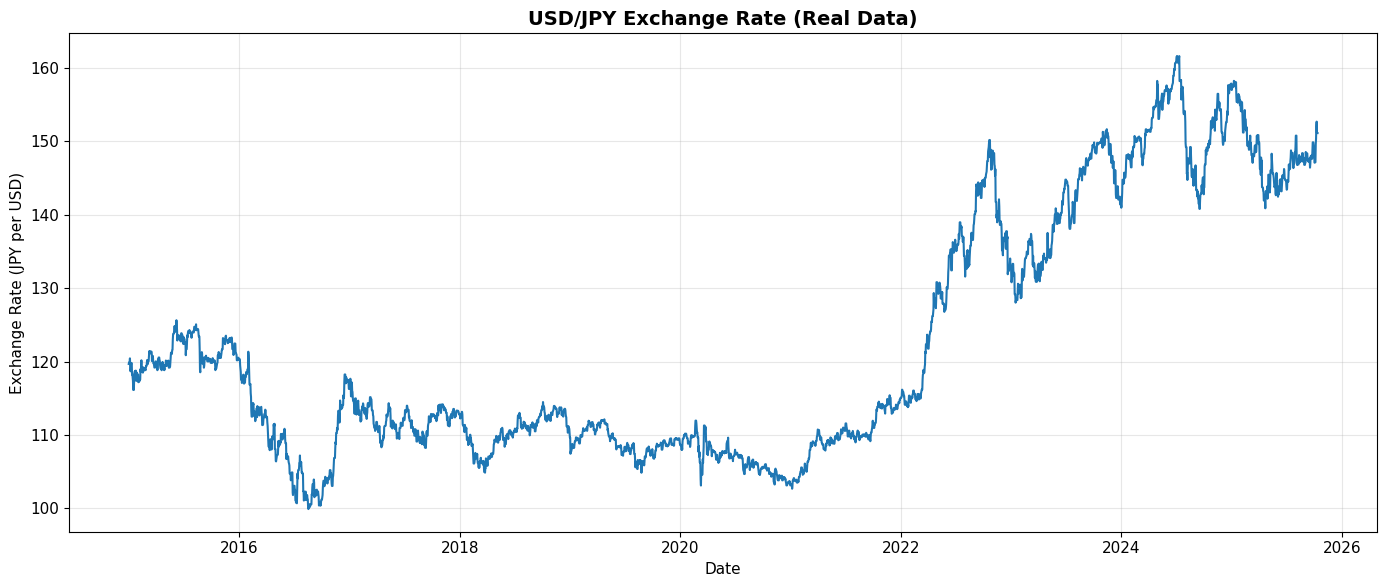


Interpretation:
- The exchange rate shows the value of 1 USD in JPY
- Upward movement = USD appreciation (favorable for carry trade)
- Downward movement = USD depreciation (unfavorable, can wipe out carry gains)


In [23]:
# Visualize exchange rate
plt.figure(figsize=(14, 6))
plt.plot(carry_df.index, carry_df['Exchange_Rate'], linewidth=1.5)
plt.title('USD/JPY Exchange Rate (Real Data)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (JPY per USD)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- The exchange rate shows the value of 1 USD in JPY")
print("- Upward movement = USD appreciation (favorable for carry trade)")
print("- Downward movement = USD depreciation (unfavorable, can wipe out carry gains)")

### 4.4 Strategy Implementation and Backtesting

In [24]:
# Calculate carry trade returns
# The CSV already contains pre-calculated returns, but let's verify and use them

# Use the pre-calculated returns from the CSV
# These are already computed as: Carry_Trade_Return = Daily_Carry + FX_Return
carry_df['Carry_Return'] = carry_df['Carry_Trade_Return']

# Use pre-calculated cumulative returns or recalculate for clarity
carry_df['Cumulative_Carry'] = carry_df['Cumulative_Interest'] + carry_df['Cumulative_FX']
carry_df['Cumulative_FX_Only'] = carry_df['Cumulative_FX']
carry_df['Cumulative_Interest_Only'] = carry_df['Cumulative_Interest']

# Remove NaN values
carry_df = carry_df.dropna()

print("Carry Trade Performance:")
print(f"\nTotal Return: {carry_df['Cumulative_Carry'].iloc[-1]*100:.2f}%")
print(f"  From Interest: {carry_df['Cumulative_Interest_Only'].iloc[-1]*100:.2f}%")
print(f"  From FX: {carry_df['Cumulative_FX_Only'].iloc[-1]*100:.2f}%")
print(f"\nAnnualized Metrics:")
years = len(carry_df) / 365
annualized_return = (1 + carry_df['Cumulative_Carry'].iloc[-1]) ** (1/years) - 1
annualized_vol = carry_df['Carry_Return'].std() * np.sqrt(365)
print(f"  Return: {annualized_return*100:.2f}%")
print(f"  Volatility: {annualized_vol*100:.2f}%")
print(f"  Sharpe Ratio: {(annualized_return - 0.02) / annualized_vol:.2f}")

Carry Trade Performance:

Total Return: 84.94%
  From Interest: 58.67%
  From FX: 26.28%

Annualized Metrics:
  Return: 15.89%
  Volatility: 10.31%
  Sharpe Ratio: 1.35


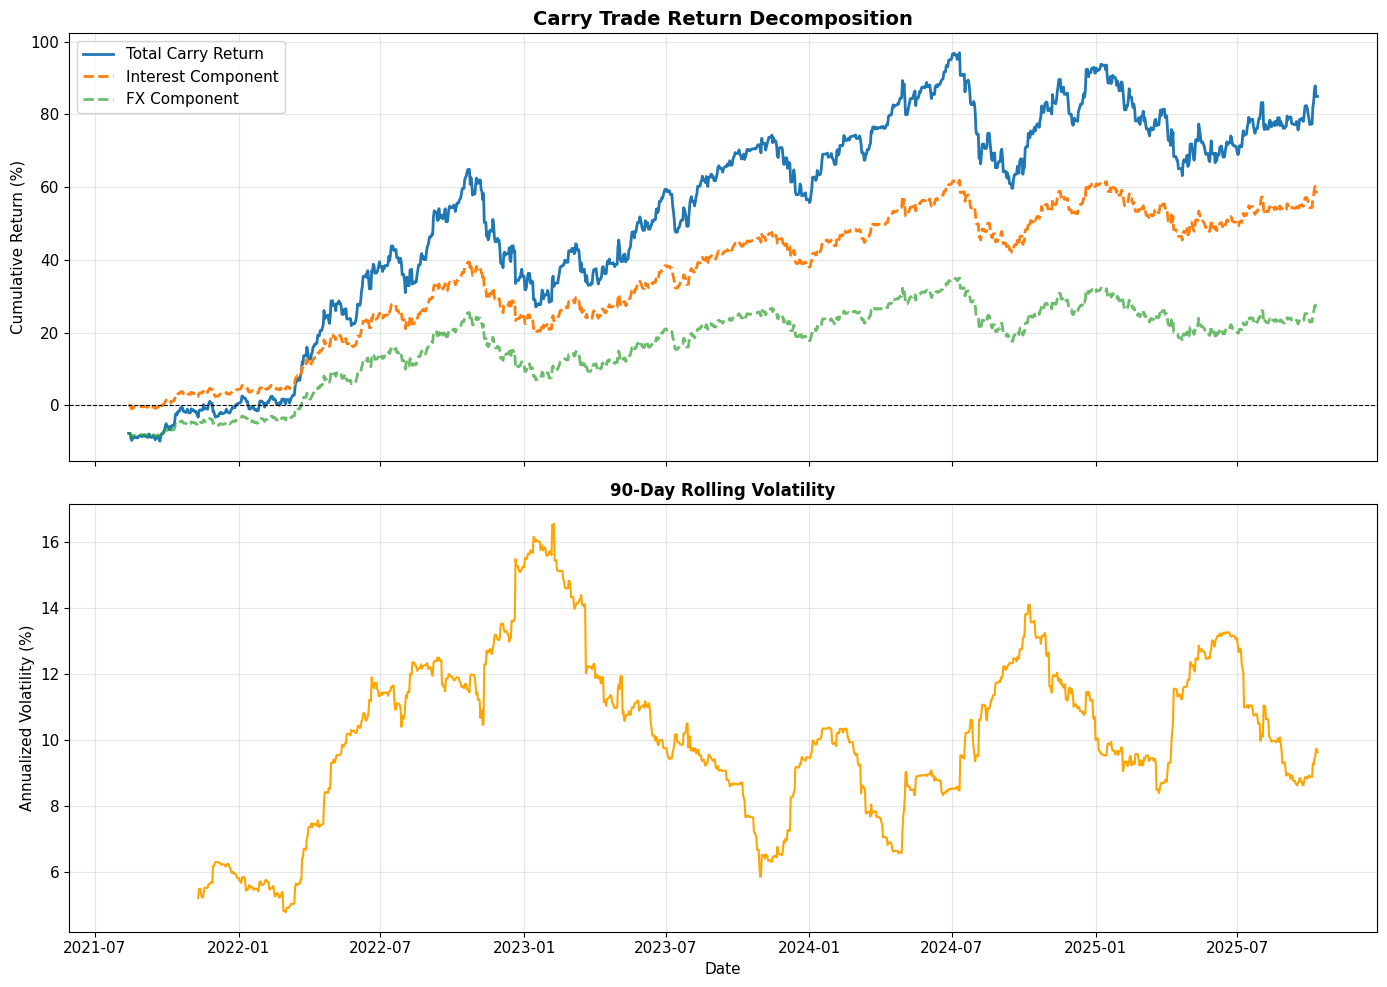


Key Observations:
1. Interest component provides steady, predictable returns
2. FX component is volatile and can dominate total returns
3. When FX moves favorably, carry trades perform excellently
4. When FX moves adversely, interest income may not compensate losses


In [25]:
# Visualize carry trade returns decomposition
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Return decomposition
ax1 = axes[0]
ax1.plot(carry_df.index, carry_df['Cumulative_Carry'] * 100, label='Total Carry Return', linewidth=2)
ax1.plot(carry_df.index, carry_df['Cumulative_Interest_Only'] * 100, '--', label='Interest Component', linewidth=2)
ax1.plot(carry_df.index, carry_df['Cumulative_FX_Only'] * 100, '--', label='FX Component', linewidth=2, alpha=0.7)
ax1.set_ylabel('Cumulative Return (%)')
ax1.set_title('Carry Trade Return Decomposition', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

# Plot 2: Rolling volatility
ax2 = axes[1]
rolling_vol = carry_df['Carry_Return'].rolling(window=90).std() * np.sqrt(365) * 100
ax2.plot(carry_df.index, rolling_vol, color='orange', linewidth=1.5)
ax2.set_ylabel('Annualized Volatility (%)')
ax2.set_xlabel('Date')
ax2.set_title('90-Day Rolling Volatility', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("1. Interest component provides steady, predictable returns")
print("2. FX component is volatile and can dominate total returns")
print("3. When FX moves favorably, carry trades perform excellently")
print("4. When FX moves adversely, interest income may not compensate losses")

### 4.5 Performance Evaluation and Risk Analysis


Carry Trade Strategy Performance Metrics
Total Return:               58.67%
Annualized Return:           7.94%
Annualized Volatility:       8.57%
Sharpe Ratio:                0.69
Maximum Drawdown:          -13.87%
Win Rate:                   68.66%
Number of Trades:            1522


Drawdown Analysis:
Maximum Drawdown: -13.87%
Average Drawdown: -4.03%
Time in drawdown: 62.9%


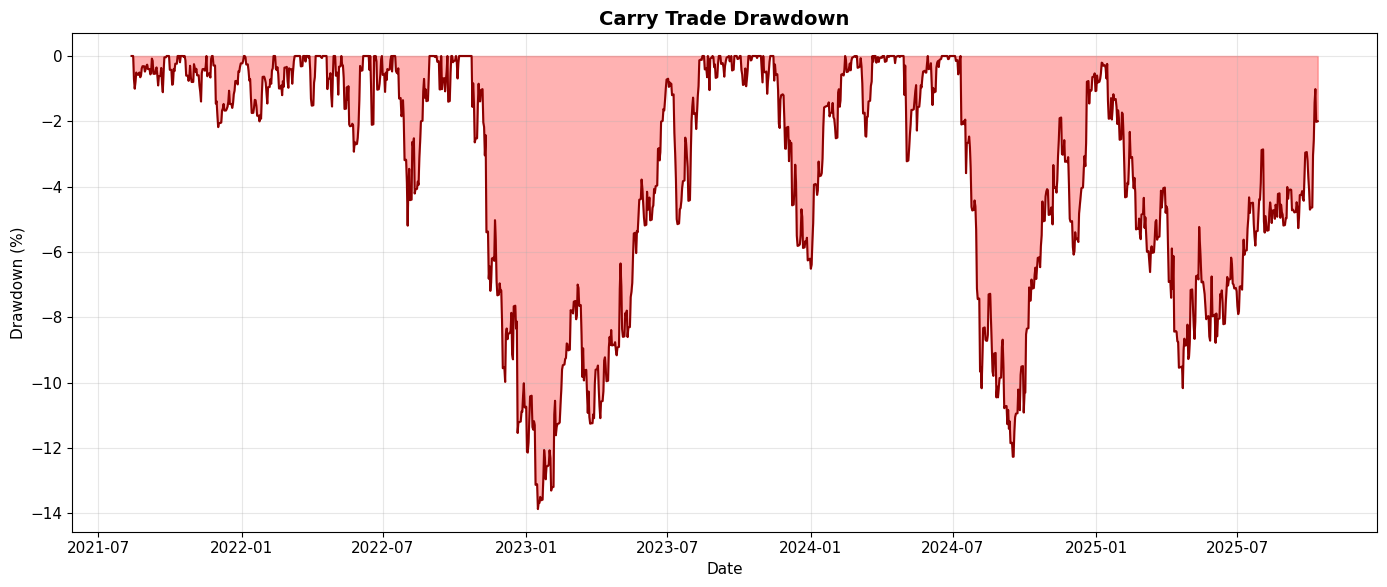

In [26]:
# Calculate performance metrics
carry_metrics = calculate_performance_metrics(carry_df['Carry_Return'], "Carry Trade Strategy")

# Analyze drawdowns (important for carry trades)
cumulative = (1 + carry_df['Carry_Return']).cumprod()
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max

print("\nDrawdown Analysis:")
print(f"Maximum Drawdown: {drawdown.min()*100:.2f}%")
print(f"Average Drawdown: {drawdown[drawdown < 0].mean()*100:.2f}%")
print(f"Time in drawdown: {(drawdown < -0.01).sum() / len(drawdown) * 100:.1f}%")

# Visualize drawdown
plt.figure(figsize=(14, 6))
plt.fill_between(carry_df.index, drawdown * 100, 0, color='red', alpha=0.3)
plt.plot(carry_df.index, drawdown * 100, color='darkred', linewidth=1.5)
plt.title('Carry Trade Drawdown', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.6 Limitations and Considerations

**Weaknesses:**
1. **Crash Risk**: "Picking up pennies in front of a steamroller" - small steady gains, large occasional losses
2. **Correlation Risk**: Carry trades across different pairs often move together during crises
3. **Leverage Risk**: Forex leverage can amplify losses dramatically
4. **Interest Rate Changes**: Central bank policy changes can eliminate carry differential

**When it works best:**
- Low volatility, risk-on environments
- Stable interest rate differentials
- Positive or neutral trends in high-yield currency
- Benign global economic conditions

**When it fails:**
- Financial crises (2008, 2020 COVID crash)
- Risk-off environments (flight to safety)
- Central bank interventions
- Sudden high-yield currency devaluation

**Famous Carry Trade Unwinds:**
- August 1998: Russian default and LTCM crisis
- October 2008: Global financial crisis
- March 2020: COVID-19 panic

During these events, carry trades can lose months of gains in days.

---

## Strategy 5: Event-Driven Strategy (Merger Arbitrage)



### 5.1 Mathematical Foundation

Merger arbitrage exploits the price difference between the current market price of a target company and the announced acquisition price.

**Simple Cash Merger:**

$$\text{Spread}_t = P_{offer} - P_{target}(t)$$

where:
- $P_{offer}$ = Acquisition offer price per share
- $P_{target}(t)$ = Current market price of target

**Expected Return:**

$$E[R] = \frac{P_{offer} - P_{target}}{P_{target}} \times \frac{365}{T}$$

where $T$ = Expected days to completion

**Risk-Adjusted Return (considering deal failure):**

$$E[R_{adj}] = p_{success} \times R_{success} + (1 - p_{success}) \times R_{failure}$$

where:
- $p_{success}$ = Probability deal closes successfully
- $R_{success}$ = Return if deal closes (spread capture)
- $R_{failure}$ = Return if deal breaks (typically large negative)




### 5.2 Intuition and Rationale

**Why does this work?**

1. **Deal Uncertainty**: Market prices reflect uncertainty about deal completion
2. **Time Value**: Spread compensates for time until deal closes
3. **Regulatory Risk**: Antitrust and regulatory approval uncertainty
4. **Financing Risk**: Acquiring company may fail to secure financing

**Market Assumptions:**
- Most announced deals close successfully (70-90% historically)
- Spread narrows as deal progresses through milestones
- Market is inefficient at pricing deal completion probability

**Deal Completion Milestones:**
1. Announcement
2. Due diligence completion
3. Shareholder approval
4. Regulatory approval
5. Financing secured
6. Deal closes


**When does this fail?**
- **Deal Breaks**: If regulatory authorities block the merger (antitrust concerns) or shareholders vote against it, the target stock typically falls sharply to pre-announcement levels, causing significant losses
- **Financing Failures**: If the acquirer cannot secure necessary funding (debt/equity markets freeze), the deal may be abandoned or renegotiated at a lower price
- **Material Adverse Change (MAC)**: Discovery of undisclosed liabilities, fraud, or major deterioration in the target's business can allow the acquirer to walk away from the deal
- **Hostile Market Conditions**: In severe market downturns, acquirers may attempt to renegotiate deal terms or abandon transactions using MAC clauses
- **Time Risk**: Prolonged regulatory reviews or litigation can tie up capital for extended periods, reducing annualized returns and exposing the position to other market risks
- **Bidding Wars**: While often beneficial, competitive bids can complicate the arbitrage position, especially if holding a hedged position that assumed a specific exchange ratio



### 5.3 Demonstration: Merger Arbitrage Spread Evolution

In [27]:
# Simulate a merger arbitrage opportunity
np.random.seed(42)

# Merger parameters
announcement_date = pd.Timestamp('2024-01-15')
expected_close_date = pd.Timestamp('2024-06-15')  # 5 months
n_days = (expected_close_date - announcement_date).days

# Price parameters
offer_price = 100.00  # Acquirer offers $100 per share
pre_announcement_price = 80.00  # Target trading at $80 before announcement
initial_post_price = 95.00  # Target jumps to $95 after announcement (5% spread)

# Create dates
dates = pd.date_range(start=announcement_date, periods=n_days, freq='D')

# Simulate target price gradually approaching offer price
# Price follows a mean-reverting process toward offer price
spread_volatility = 0.01  # Daily volatility of spread
spread_changes = np.random.randn(n_days) * spread_volatility

# Gradual convergence to offer price (reducing uncertainty over time)
time_factor = np.linspace(1, 0, n_days)  # Decreases from 1 to 0
target_prices = offer_price - (offer_price - initial_post_price) * time_factor + np.cumsum(spread_changes)

# Ensure prices don't exceed offer price
target_prices = np.minimum(target_prices, offer_price - 0.10)

# Create DataFrame
merger_df = pd.DataFrame({
    'Target_Price': target_prices,
    'Offer_Price': offer_price,
    'Spread': offer_price - target_prices,
    'Spread_Pct': (offer_price - target_prices) / target_prices * 100
}, index=dates)

# Add key milestone dates
milestones = {
    'Announcement': announcement_date,
    'Shareholder Approval': announcement_date + pd.Timedelta(days=60),
    'Regulatory Filing': announcement_date + pd.Timedelta(days=90),
    'Regulatory Approval': announcement_date + pd.Timedelta(days=120),
    'Expected Close': expected_close_date
}

print("Merger Arbitrage Simulation:")
print(f"\nDeal Parameters:")
print(f"  Offer Price: ${offer_price:.2f}")
print(f"  Pre-announcement Price: ${pre_announcement_price:.2f}")
print(f"  Post-announcement Price: ${initial_post_price:.2f}")
print(f"  Initial Spread: ${offer_price - initial_post_price:.2f} ({(offer_price - initial_post_price)/initial_post_price*100:.2f}%)")
print(f"\nDeal Timeline:")
for milestone, date in milestones.items():
    print(f"  {milestone}: {date.strftime('%Y-%m-%d')}")
print(f"\nCurrent Target Price: ${merger_df['Target_Price'].iloc[-1]:.2f}")
print(f"Current Spread: ${merger_df['Spread'].iloc[-1]:.2f} ({merger_df['Spread_Pct'].iloc[-1]:.2f}%)")

Merger Arbitrage Simulation:

Deal Parameters:
  Offer Price: $100.00
  Pre-announcement Price: $80.00
  Post-announcement Price: $95.00
  Initial Spread: $5.00 (5.26%)

Deal Timeline:
  Announcement: 2024-01-15
  Shareholder Approval: 2024-03-15
  Regulatory Filing: 2024-04-14
  Regulatory Approval: 2024-05-14
  Expected Close: 2024-06-15

Current Target Price: $99.88
Current Spread: $0.12 (0.12%)


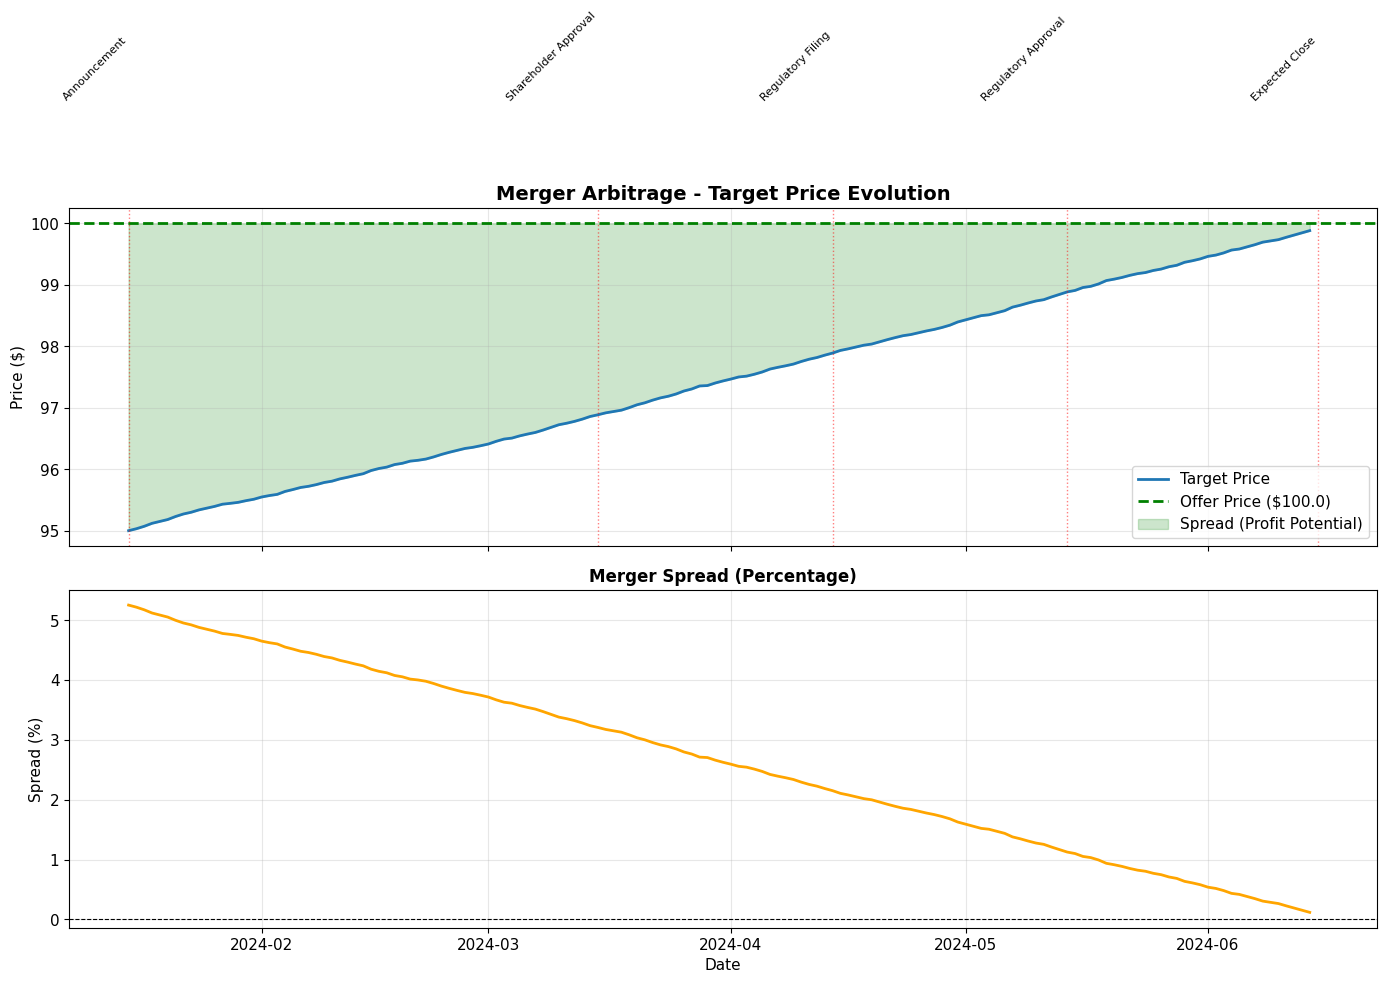


Interpretation:
- The spread (difference between offer and market price) represents profit potential
- As deal progresses through milestones, uncertainty decreases and spread narrows
- At each milestone, if positive news, spread tightens (price rises toward offer)
- Arbitrageurs earn the spread if/when deal closes


In [28]:
# Visualize merger spread evolution
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Price evolution
ax1 = axes[0]
ax1.plot(merger_df.index, merger_df['Target_Price'], label='Target Price', linewidth=2)
ax1.axhline(y=offer_price, color='green', linestyle='--', linewidth=2, label=f'Offer Price (${offer_price})')
ax1.fill_between(merger_df.index, merger_df['Target_Price'], offer_price, alpha=0.2, color='green', label='Spread (Profit Potential)')

# Mark milestones
for milestone, date in milestones.items():
    if announcement_date <= date <= expected_close_date:
        ax1.axvline(x=date, color='red', linestyle=':', alpha=0.5, linewidth=1)
        ax1.text(date, offer_price * 1.02, milestone, rotation=45, ha='right', fontsize=8)

ax1.set_ylabel('Price ($)')
ax1.set_title('Merger Arbitrage - Target Price Evolution', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Spread evolution
ax2 = axes[1]
ax2.plot(merger_df.index, merger_df['Spread_Pct'], color='orange', linewidth=2)
ax2.set_ylabel('Spread (%)')
ax2.set_xlabel('Date')
ax2.set_title('Merger Spread (Percentage)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- The spread (difference between offer and market price) represents profit potential")
print("- As deal progresses through milestones, uncertainty decreases and spread narrows")
print("- At each milestone, if positive news, spread tightens (price rises toward offer)")
print("- Arbitrageurs earn the spread if/when deal closes")

### 5.4 Strategy Implementation and Return Calculation

In [29]:
# Calculate merger arbitrage returns
# Assume we buy target stock at announcement and hold until close

# Entry: Buy at post-announcement price
entry_price = initial_post_price
entry_date = announcement_date

# Exit scenarios
deal_success = True  # Assume deal closes successfully
exit_price = offer_price if deal_success else pre_announcement_price * 0.85  # If fails, expect 15% drop
exit_date = expected_close_date

# Calculate returns
holding_period_days = n_days
total_return = (exit_price - entry_price) / entry_price
annualized_return = (1 + total_return) ** (365 / holding_period_days) - 1

# Calculate daily returns assuming linear spread compression
merger_df['Daily_Return'] = merger_df['Target_Price'].pct_change()
merger_df['Cumulative_Return'] = (1 + merger_df['Daily_Return']).cumprod() - 1
merger_df['Position_Value'] = 10000 * (1 + merger_df['Cumulative_Return'])  # $10k initial investment

print(f"Merger Arbitrage Returns:")
print(f"\nEntry:")
print(f"  Date: {entry_date.strftime('%Y-%m-%d')}")
print(f"  Price: ${entry_price:.2f}")
print(f"  Initial Spread: ${offer_price - entry_price:.2f} ({(offer_price - entry_price)/entry_price*100:.2f}%)")
print(f"\nExit (assuming deal closes):")
print(f"  Date: {exit_date.strftime('%Y-%m-%d')}")
print(f"  Price: ${exit_price:.2f}")
print(f"  Holding Period: {holding_period_days} days ({holding_period_days/30:.1f} months)")
print(f"\nReturns:")
print(f"  Total Return: {total_return*100:.2f}%")
print(f"  Annualized Return: {annualized_return*100:.2f}%")
print(f"\nRisk Analysis:")
print(f"  If deal breaks, estimated loss: {((pre_announcement_price*0.85 - entry_price)/entry_price)*100:.2f}%")
print(f"  Break-even deal success probability: {(entry_price - pre_announcement_price*0.85)/(offer_price - pre_announcement_price*0.85)*100:.1f}%")

Merger Arbitrage Returns:

Entry:
  Date: 2024-01-15
  Price: $95.00
  Initial Spread: $5.00 (5.26%)

Exit (assuming deal closes):
  Date: 2024-06-15
  Price: $100.00
  Holding Period: 152 days (5.1 months)

Returns:
  Total Return: 5.26%
  Annualized Return: 13.11%

Risk Analysis:
  If deal breaks, estimated loss: -28.42%
  Break-even deal success probability: 84.4%


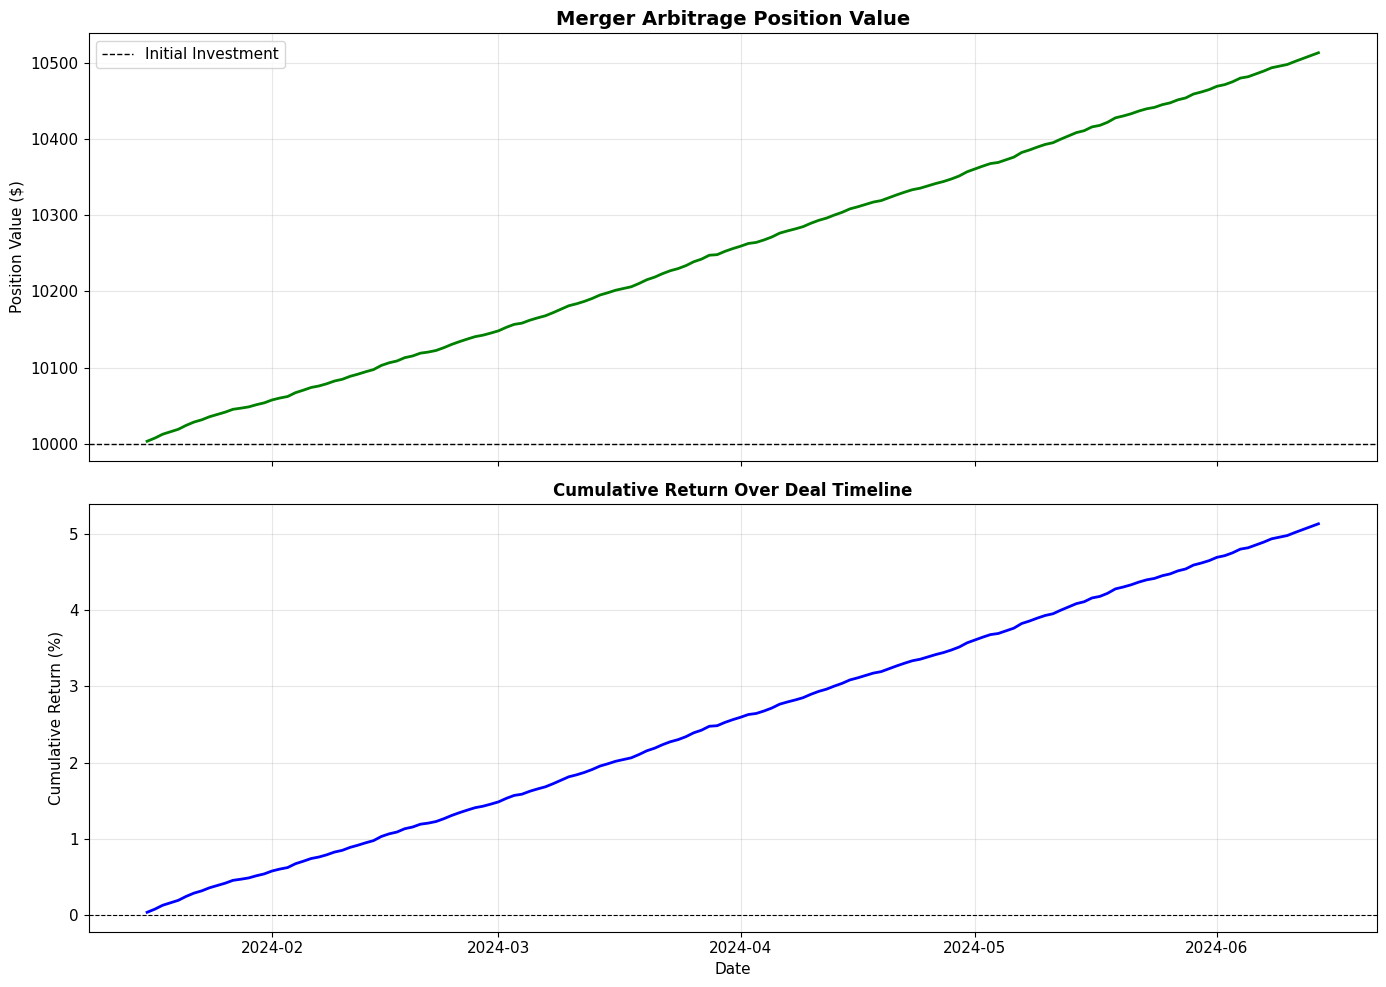

In [30]:
# Visualize position value over time
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Position value
ax1 = axes[0]
ax1.plot(merger_df.index, merger_df['Position_Value'], linewidth=2, color='green')
ax1.axhline(y=10000, color='black', linestyle='--', linewidth=1, label='Initial Investment')
ax1.set_ylabel('Position Value ($)')
ax1.set_title('Merger Arbitrage Position Value', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative return
ax2 = axes[1]
ax2.plot(merger_df.index, merger_df['Cumulative_Return'] * 100, linewidth=2, color='blue')
ax2.set_ylabel('Cumulative Return (%)')
ax2.set_xlabel('Date')
ax2.set_title('Cumulative Return Over Deal Timeline', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

### 5.5 Performance Evaluation

In [31]:
# Calculate performance metrics
merger_metrics = calculate_performance_metrics(merger_df['Daily_Return'], "Merger Arbitrage Strategy")

print("\nMerger Arbitrage Characteristics:")
print(f"Average daily spread compression: ${merger_df['Spread'].diff().mean():.4f}")
print(f"Spread volatility: ${merger_df['Spread'].std():.2f}")
print(f"Days until deal close: {holding_period_days}")
print(f"\nHistorical Deal Statistics (typical):")
print(f"  Deal success rate: 70-90%")
print(f"  Average spread at announcement: 3-7%")
print(f"  Average time to completion: 3-4 months")
print(f"  Annualized returns: 7-12% (with leverage)")


Merger Arbitrage Strategy Performance Metrics
Total Return:                5.13%
Annualized Return:           8.71%
Annualized Volatility:       0.15%
Sharpe Ratio:               43.94
Maximum Drawdown:            0.00%
Win Rate:                  100.00%
Number of Trades:             151


Merger Arbitrage Characteristics:
Average daily spread compression: $-0.0323
Spread volatility: $1.42
Days until deal close: 152

Historical Deal Statistics (typical):
  Deal success rate: 70-90%
  Average spread at announcement: 3-7%
  Average time to completion: 3-4 months
  Annualized returns: 7-12% (with leverage)


### 5.6 Limitations and Considerations

**Weaknesses:**
1. **Left-Tail Risk**: Small steady gains but large losses if deal breaks (20-40% loss)
2. **Deal-Specific Risk**: Each merger has unique regulatory, financing, and strategic risks
3. **Timing Uncertainty**: Deals can take longer than expected, reducing annualized returns
4. **Limited Opportunities**: Requires access to deal flow and quick execution

**Reasons Deals Break:**
- Regulatory rejection (antitrust concerns)
- Financing falls through
- Material adverse change (MAC) in target business
- Shareholder rejection
- Buyer gets cold feet (hostile situations)

**When it works best:**
- Friendly, all-cash deals
- Strategic buyers (not financial)
- Low regulatory risk
- Well-financed acquirer
- Strong shareholder support

**When it fails:**
- Hostile takeovers
- High antitrust risk
- Leveraged deals during credit crunches
- Target business deteriorates
- Market crashes (financing dries up)

**Real-World Examples:**
- **Successful**: Disney / 21st Century Fox (2019) - spread narrowed steadily
- **Failed**: AT&T / T-Mobile (2011) - blocked by regulators, T-Mobile shares dropped

### Key Takeaways

1. **No Single Best Strategy**: Each strategy performs well in different market conditions

2. **Risk-Return Tradeoff**: Higher returns often come with higher risks or tail risks

3. **Diversification**: Combining multiple strategies can improve risk-adjusted returns

4. **Market Regimes Matter**: Understand current market regime and select appropriate strategies

5. **Transaction Costs**: Real-world implementation requires careful consideration of:
   - Commissions and fees
   - Bid-ask spreads
   - Slippage
   - Market impact

6. **Risk Management**: All strategies require:
   - Position sizing
   - Stop losses
   - Portfolio limits
   - Stress testing

7. **Backtesting Limitations**:
   - Survivorship bias
   - Look-ahead bias
   - Overfitting
   - Market microstructure changes

### Further Study

For deeper understanding:
- **Academic Papers**: Research on strategy performance, risk factors, and behavioral finance
- **Books**: 
  - "Quantitative Trading" by Ernie Chan
  - "Trading and Exchanges" by Larry Harris
  - "Inside the House of Money" by Steven Drobny
- **Practice**: Paper trading and gradual position sizing in live markets
- **Risk Management**: Study portfolio theory and risk management techniques

---

## Exercises

1. **Strategy Modification**: Take one of the strategies above and modify its parameters. How does performance change?

2. **Combination Strategy**: Create a strategy that combines signals from multiple approaches (e.g., MA crossover + RSI)

3. **Risk Management**: Add stop-loss and take-profit rules to any strategy. Measure the impact.

4. **Market Regime Detection**: Develop an algorithm to detect market regime (trending vs. mean-reverting) and switch strategies accordingly

5. **Transaction Costs**: Add realistic transaction costs (0.1% per trade) and re-evaluate strategy performance

6. **Out-of-Sample Testing**: Split data into training and testing periods. Optimize parameters on training data and test on unseen data

7. **Portfolio Construction**: Allocate capital across multiple strategies. Calculate portfolio-level metrics.

8. **Real Data Application**: Apply these strategies to real market data from different asset classes